# Harmonizing and Benchmarking FiPy's Solver Suites

## What's the problem?

FiPy relies on 3rd party packages for linear solving:
- PySparse (serial, Python 2.7 only)
- SciPy (serial)
- PyTrilinos (MPI parallel)
- petsc4py (MPI parallel)
- pyamgx (GPU (CPU serial))

**Q:** Why do we still support PySparse?
- [Python 3 came out 14 years ago](https://docs.python.org/release/3.0/)
- [Python 2.7 was declared officially end of life on January 1st (April 20th), 2020](https://www.python.org/doc/sunset-python-2/)
- [PySparse was abandoned by it's author in 2010](https://sourceforge.net/p/pysparse/git/ci/0bd1d8da1ffc4a0d3e2abc457ccc2ca9cb44ccba/log/?path=)

**A:** It's *fast* (at least we think so...) and many FiPy users (Windows) can't take advantage of MPI parallelism

**A':** How do we know?

**A'':** And compared to what?

## Approach

- Ensure that all solver suites are doing the same thing (*i.e.*, what do "tolerance" and "residual" mean?)
- Compare widest combinations of solvers and preconditioners in *serial*

    (PySparse is serial-only and the question is whether we need to continue supporting PySparse)
- Choose benchmark problems that illuminate the effect of solver choice and system size and not artifacts of length scale or incubation time

## Code

In [ ]:
datapath = "../../../../solvers_and_timings/results"

### imports

In [102]:
import collections
import glob
import json
import os
import uuid

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
import pandas as pd
from scipy import ndimage

import fipy as fp

### utilities

### I/O

#### logs

In [103]:
def read_events(fname):
    success_statuses = ['KSP_CONVERGED_RTOL', 'SCIPY_SUCCESS', 'AZ_normal', 
                        'KSP_CONVERGED_ITS', 'KSP_CONVERGED_RTOL', 
                        'Pysparse_CONVERGED_RTOL', 'AMGX_SOLVE_SUCCESS']
    events = []
    state = {}
    versions = {}

    with open(fname, 'r') as f:
        begin_time = np.nan
        solve_time = np.nan
        simulation_id = np.nan
        for line in f:
            entries = line.split("|")
            # Python version uses '|', too
            entries = entries[:4] + ["|".join(entries[4:])]

            (time_stamp,
             level,
             logger,
             function,
             msg) = [s.strip() for s in entries]

            if (logger, function) == ("fipy.solvers", "<module>"):
                pass
            elif (level, logger, function) == ("DEBUG", "fipy", "<module>"):
                versions = json.loads(msg)
                # # fix name collision
                # versions["package"]["solver_suite"] = versions["package"]["solver"]
                # del versions["package"]["solver"]
            elif (level, logger, function) == ("INFO", "fipy", "<module>"):
                # obsolete log format
                versions = {"package": json.loads(msg)}
            elif (level, function) == ("DEBUG", "<module>"):
                if msg.startswith("result stored in"):
                    continue
                state = json.loads(msg)
                state["logfile"] = fname
                state["time_stamp"] = time_stamp
                state["solver_class"] = logger.split('.')[-1]
                state["solve_time"] = str(solve_time)
                if state["state"] == "START":
                    # create unique id for each simulation run
                    simulation_id = uuid.uuid4()
                    converged = False
                state["simulation_id"] = simulation_id
                state["converged"] = converged
                state.update(versions)
                events.append(state.copy())
            elif (level, function) == ("DEBUG", "_setConvergence"):
                state["state"] = "SWEEP"
                event = json.loads(msg)
                event.update(state.copy())
                event["time_stamp"] = time_stamp
                event["solver_class"] = logger.split('.')[-1]
                event["solve_time"] = str(solve_time)
                converged = event["status_name"] in success_statuses
                events.append(event)
                solve_time = np.nan
            elif (level, function) == ("DEBUG", "_solve_"):
                if msg == "BEGIN solve":
                    begin_time = pd.to_datetime(time_stamp)
                    solve_time = np.nan
                elif msg == "END solve":
                    solve_time = pd.to_datetime(time_stamp) - begin_time
                    begin_time = np.nan

    return events

def events2df(events):
    df = pd.json_normalize(events)
    df["time_stamp"] = pd.to_datetime(df["time_stamp"])
    df["solve_time"] = pd.to_timedelta(df["solve_time"])    
    df.loc[df["preconditioner"].isna()
           | (df["preconditioner"] == "NoneType"), "preconditioner"] = "unpreconditioned"

    return df

def extract_total_times(df):
    solve_time = df.groupby("simulation_id")["solve_time"].sum()
    
    df2 = df[df["state"].isin(["START", "END"])].copy()
    df2["time_delta"] = df2["time_stamp"].diff()
    df2 = df2[df2["state"] == "END"].set_index("simulation_id")
    df2["solve_time"] = solve_time
    
    df2["elapsed_seconds"] = df2["time_delta"] / pd.Timedelta("00:00:01")
    df2["solve_seconds"] = df2["solve_time"] / pd.Timedelta("00:00:01")

    return df2.sort_values("numberOfElements")

def extract_sweep_times(df):
    df2 = df.copy()
    df2["time_delta"] = df["time_stamp"].diff()
    df2["elapsed_seconds"] = df2["time_delta"] / pd.Timedelta("00:00:01")

    return df2[~df2["state"].isin(["START", "END"])]

#### data files

In [104]:
def read_tsv(tsv):
    x, y, v = np.loadtxt(tsv, skiprows=1, unpack=True)
    N = int(np.sqrt(len(x)))
    return [field.reshape((N,N)) for field in (x, y, v)] + [N]

def read_npz(npz):
    data = np.load(npz)
    return data["x"], data["y"], data["value"], data["value"].shape[0]

def tsv2npz(tsv):
    x, y, v, N = read_tsv(tsv)
    np.savez(os.path.splitext(tsv)[0], x=x, y=y, value=v)

In [105]:
def load_field(record, fname, key):
    """Load and intorpolate `path2` to resolution of `path1`
    
    Parameters
    ----------
    record : pd.Series
        Pandas Series with information about particular results to load.
    fname : str
        Name of `.npz` file containing x-coordinates, y-coordinates, and values
        to load from directory hierarchy determined by "logfile",
        "package.solver", "solver_class", "preconditioner", "numberOfElements"
        fields in `record`.
    key : str
        Designation of the field of interest within `fname`.

    Returns
    -------
    field : ndarray
        2D array of values.
    """
    preconditioner = record["preconditioner"]
    if preconditioner == "unpreconditioned":
        preconditioner = "NoneType"

    path = os.path.join(os.path.dirname(record["logfile"]),
                        record["package.solver"], record["solver_class"],
                        preconditioner, str(record["numberOfElements"]),
                        fname)

    try:
        with np.load(path) as data:
            field = data[key]
    except:
        field = None

    return field

### plot scaling

In [106]:
def plot_all(df, color_by_suite=True,
             by=["package.solver", "solver_class", "preconditioner"],
             solve_time=False):
    color_map = {
        'no-pysparse': 'red',
        'trilinos': 'red',
        'petsc': 'blue',
        'scipy': 'green',
        'pysparse': 'orange',
        'pyamgx': 'cyan'
    }
    
    fig, ax = plt.subplots(figsize=(8,6))
    groups = df.groupby(by + ["numberOfElements"])
    groups = groups.agg(converged=("converged", "all"),
                        elapsed_count=("elapsed_seconds", "count"),
                        elapsed_mean=("elapsed_seconds", "mean"),
                        elapsed_std=("elapsed_seconds", "std"),
                        solve_count=("solve_seconds", "count"),
                        solve_mean=("solve_seconds", "mean"),
                        solve_std=("solve_seconds", "std")).reset_index()
    groups = groups.groupby(by)
    for key, group in groups:
        if color_by_suite:
            color = color_map[key[0]]
            group.mask(~group["converged"].astype(bool)).plot("numberOfElements", "elapsed_mean", loglog=True,
                       ax=ax, label=key, color=color, marker=".", markersize=1.5)
            group.mask(group["converged"].astype(bool)).plot("numberOfElements", "elapsed_mean", loglog=True,
                       ax=ax, label=None, color=color, marker="x", linestyle="")
            
            if solve_time:
                group.mask(~group["converged"].astype(bool)).plot("numberOfElements", "solve_mean", loglog=True,
                           ax=ax, label=key, color=color, marker=".", markersize=1.5, linestyle="--")
                group.mask(group["converged"].astype(bool)).plot("numberOfElements", "solve_mean", loglog=True,
                           ax=ax, label=None, color=color, marker="+", linestyle="")
        else:
            group.mask(~group["converged"].astype(bool)).plot("numberOfElements", "elapsed_mean", loglog=True,
                       ax=ax, label=key, marker=".", markersize=1.5)
            color = ax.lines[-1].get_color()
            group.mask(group["converged"].astype(bool)).plot("numberOfElements", "elapsed_mean", loglog=True,
                       ax=ax, label=None, color=color, marker="x", linestyle="")
            
            if solve_time:
                group.mask(~group["converged"].astype(bool)).plot("numberOfElements", "solve_mean", loglog=True,
                           ax=ax, label=key, color=color, marker=".", markersize=1.5, linestyle="--")
                group.mask(group["converged"].astype(bool)).plot("numberOfElements", "solve_mean", loglog=True,
                           ax=ax, label=None, color=color, marker="+", linestyle="")

        # plot uncertainty
        err = group["elapsed_std"] / np.sqrt(group["elapsed_count"])
        ax.fill_between(group["numberOfElements"],
                        group["elapsed_mean"] - err,
                        group["elapsed_mean"] + err,
                        color=color,
                        alpha=0.1)

    if color_by_suite:
        legend_elements = [Line2D([0], [0], color=c, label=s)
                           for s, c in color_map.items()
                           if s in df["package.solver"].unique()]
        ax.legend(handles=legend_elements, bbox_to_anchor=(1., 1.))
    else:
        # only label converged lines
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::2], labels[::2], bbox_to_anchor=(1., 1.))

    if ~df["converged"].astype(bool).all():
        legend_elements = [Line2D([0], [0], color="black", marker=".", markersize=1.5),
                           Line2D([0], [0], color="black", linewidth=0, marker="x")]
        labels = ["converged", "not converged"]

        if solve_time:
            legend_elements.append(Line2D([0], [0], color="black", marker=".", markersize=1.5, linestyle="--"))
            labels.append("solve time")

        leg = Legend(ax, handles=legend_elements, labels=labels,
                     loc='upper left', frameon=False)
        ax.add_artist(leg);

    ax.set_ylabel("elapsed time / s")
    ax.set_xlabel("number of elements")

def plot_solve_fraction(df, color_by_suite=True,
             by=["package.solver", "solver_class", "preconditioner"]):
    color_map = {
        'no-pysparse': 'red',
        'trilinos': 'red',
        'petsc': 'blue',
        'scipy': 'green',
        'pysparse': 'orange',
        'pyamgx': 'cyan'
    }
    
    fig, ax = plt.subplots(figsize=(8,6))
    df = df.copy()
    df["solve_fraction"] = df["solve_seconds"] / df["elapsed_seconds"]
    groups = df.groupby(by + ["numberOfElements"])
    groups = groups.agg(converged=("converged", "all"),
                        elapsed_count=("elapsed_seconds", "count"),
                        elapsed_mean=("elapsed_seconds", "mean"),
                        elapsed_std=("elapsed_seconds", "std"),
                        solve_count=("solve_seconds", "count"),
                        solve_mean=("solve_seconds", "mean"),
                        solve_std=("solve_seconds", "std"),
                        solve_fraction_count=("solve_fraction", "count"),
                        solve_fraction_mean=("solve_fraction", "mean"),
                        solve_fraction_std=("solve_fraction", "std")).reset_index()
    
    groups = groups.groupby(by)
    for key, group in groups:
        if color_by_suite:
            color = color_map[key[0]]
            group.mask(~group["converged"].astype(bool)).plot("numberOfElements", "solve_fraction_mean", logx=True,
                       ax=ax, label=key, color=color, marker=".", markersize=1.5)
            group.mask(group["converged"].astype(bool)).plot("numberOfElements", "solve_fraction_mean", logx=True,
                       ax=ax, label=None, color=color, marker="x", linestyle="")
        else:
            group.mask(~group["converged"].astype(bool)).plot("numberOfElements", "solve_fraction_mean", logx=True,
                       ax=ax, label=key, marker=".", markersize=1.5)
            color = ax.lines[-1].get_color()
            group.mask(group["converged"].astype(bool)).plot("numberOfElements", "solve_fraction_mean", logx=True,
                       ax=ax, label=None, color=color, marker="x", linestyle="")
            
        # plot uncertainty
        err = group["solve_fraction_std"] / np.sqrt(group["solve_fraction_count"])
        ax.fill_between(group["numberOfElements"],
                        group["solve_fraction_mean"] - err,
                        group["solve_fraction_mean"] + err,
                        color=color,
                        alpha=0.1)

    if color_by_suite:
        legend_elements = [Line2D([0], [0], color=c, label=s)
                           for s, c in color_map.items()
                           if s in df["package.solver"].unique()]
        ax.legend(handles=legend_elements, bbox_to_anchor=(1., 1.))
    else:
        # only label converged lines
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::2], labels[::2], bbox_to_anchor=(1., 1.))

    if ~df["converged"].astype(bool).all():
        legend_elements = [Line2D([0], [0], color="black", marker=".", markersize=1.5),
                           Line2D([0], [0], color="black", linewidth=0, marker="x")]
        leg = Legend(ax, handles=legend_elements, labels=["converged", "not converged"],
                     loc='upper left', frameon=False)
        ax.add_artist(leg);

    ax.set_ylabel("solve fraction")
    ax.set_xlabel("number of elements")

def plot_by_solver(df):
    for solver_class, group1 in df.groupby(["solver_class"]):
        plot_all(group1, by=["package.solver", "preconditioner"])
        plt.title(solver_class)
        
def plot_sweep_times(df):
    for numberOfElements, group1 in df.groupby("numberOfElements"):
        fig, ax = plt.subplots(figsize=(8,6))
        for label, group2 in group1.groupby(["package.solver", "solver_class", "preconditioner"]):
            group2 = group2.reset_index()
            group2.plot(y="elapsed_seconds", ax=ax, label=label, logy=True)
        _ = plt.xlim(xmax=9)
        plt.legend(loc="upper right", bbox_to_anchor=(1.7, 1.0))
        plt.title("size = {0}x{0}".format(int(np.sqrt(numberOfElements))))
        plt.ylabel("sweep time / s")
        plt.xlabel("sweep")        

### plot solutions

In [107]:
def scale_and_diff(v1, v2):
    """Interpolate and calculate difference between `v1` and `v2`
    
    Parameters
    ----------
    v1, v2 : ndarray
        Square arrays of values.

    Returns
    -------
    diff : ndarray
        Difference between `v1` and `v2`
        (at resolution of whichever is lower).
    """
    if v1 is None or v2 is None:
        return None

    N1 = v1.shape[0]
    N2 = v2.shape[0]

    if N1 == N2:
        diff = v2 - v1
    elif N2 > N1:
        diff = ndimage.zoom(v2, N1 / N2) - v1
    else:
        diff = v2 - ndimage.zoom(v1, N2 / N1)
    
    return abs(diff)

def extract_and_diff(v1, v2):
    """Slice and calculate difference between `v1` and `v2`
    
    Parameters
    ----------
    v1, v2 : ndarray
        Square arrays of values.

    Returns
    -------
    diff : ndarray
        Difference between `v1` and `v2`
        (at size of whichever is smaller).
    """
    if v1 is None or v2 is None:
        return None

    N1 = v1.shape[0]
    N2 = v2.shape[0]

    if N1 == N2:
        diff = v2 - v1
    elif N2 > N1:
        lower, upper = int((N2 - N1) / 2), int((N2 + N1) / 2)
        diff = v2[lower:upper, lower:upper] - v1
    else:
        lower, upper = int((N1 - N2) / 2), int((N1 + N2) / 2)
        diff = v2 - v1[lower:upper, lower:upper]
    
    return abs(diff)

def value1(v1, v2):
    """Extract part of `v1` corresponding to `v2`.
    
    Parameters
    ----------
    v1, v2 : ndarray
        Square arrays of values.

    Returns
    -------
    value : ndarray
        Slice of `v1` that overlaps with `v2`.
    """
    if v1 is None or v2 is None:
        return None

    N1 = v1.shape[0]
    N2 = v2.shape[0]

    if N1 <= N2:
        value = v1
    else:
        lower, upper = (N1 - N2) // 2, (N1 + N2) // 2
        value = v1[lower:upper, lower:upper]
    
    return value

def value2(v1, v2):
    """Extract part of `v2` corresponding to `v1`.
    
    Parameters
    ----------
    v1, v2 : ndarray
        Square arrays of values.

    Returns
    -------
    value : ndarray
        Slice of `v1` that overlaps with `v2`.
    """
    if v1 is None or v2 is None:
        return None

    N1 = v1.shape[0]
    N2 = v2.shape[0]

    if N1 >= N2:
        value = v2
    else:
        lower, upper = int((N2 - N1) / 2), int((N2 + N1) / 2)
        value = v2[lower:upper, lower:upper]
    
    return value

In [108]:
def perpendicular_label(ax, baseline, color, label, rows):
    """Annotate text perpendicular to the outer edge of axes.
    
    Parameters
    ----------
    ax : ~matploblib.axes.Axes
        Where to apply label.
    baseline : float
        The distance from the axes to position the label.
    color : color
        The foreground color of the label.
    label : str
        The text of the label.
    rows : bool
        Whether to apply label to rows or columns.

    Returns
    -------
    ann : ~matplotlib.text.Annotation
        The displayed label.
    """
    kwargs = dict(text=label, size=8, color=color,
                  textcoords='offset points', xycoords='axes fraction')
    if rows:
        ann = ax.annotate(xy=(0.5, 1), xytext=(0, baseline), rotation=90,
                          ha='center', va='bottom', **kwargs)
    else:
        ann = ax.annotate(xy=(0, 0.5), xytext=(-baseline, 0), rotation=0,
                          ha='right', va='center', **kwargs)
    return ann

def parallel_label(ax, baseline, color, label, rows):
    """Annotate text parallel to the outer edge of axes.
    
    Parameters
    ----------
    ax : ~matploblib.axes.Axes
        Where to apply label.
    baseline : float
        The distance from the axes to position the label.
    color : color
        The foreground color of the label.
    label : str
        The text of the label.
    rows : bool
        Whether to apply label to rows or columns.

    Returns
    -------
    ann : ~matplotlib.text.Annotation
        The displayed label.
    """
    kwargs = dict(text=label, size=10, color=color,
                  textcoords='offset points', xycoords='axes fraction',
                  ha='center', va='center')
    if rows:
        ann = ax.annotate(xy=(0.5, 1), xytext=(0, baseline), rotation=0,
                          **kwargs)
    else:
        ann = ax.annotate(xy=(0, 0.5), xytext=(-baseline, 0), rotation=90,
                          **kwargs)
    return ann

def all_converged(df):
    """Determine whether all elements are converged.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Pandas object with a boolean "converged" field.

    Returns
    -------
    bool
        Whether all elements of `df` are converged.
    """
    try:
        # df is a Series
        converged = bool(df.all())
    except ValueError:
        # df is a DataFrame
        converged = bool(df.all().all())
        
    return converged

def label_width(ann, rows):
    """Calculate display width of label annotation.
    
    Parameters
    ----------
    ann : ~matplotlib.text.Annotation
        The displayed label.
    rows : bool
        Whether label was applied to rows or columns.
    
    Returns
    -------
    float
        Width of :class:`~matplotlib.transforms.Bbox` of label
        perpendicular to rows (columns).
    """
    renderer = ann.figure.canvas.get_renderer()
    bbox = ann.get_window_extent(renderer=renderer)
    if rows:
        width = bbox.y1 - bbox.y0
    else:
        width = bbox.x1 - bbox.x0

    return width

def annotate_label(df, ax, name, label, rows, baseline, perpendicular):
    """Apply label to subplot.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Pandas object with a boolean "converged" field.
    ax : ~matploblib.axes.Axes
        Where to display difference image.
    name : str
        Name for this level of index labels.
    label
        Value of index
    rows : bool
        Whether to apply labels to rows or columns.
    baseline : float
        The distance from the axes to position the label.
    perpendicular : bool
        Whether label should be perpendicular to rows (columns) or parallel.

    Returns
    -------
    ann : ~matplotlib.text.Annotation
        The displayed label.
    width : float
        Displayed width of :class:`~matplotlib.transforms.Bbox` of label
        perpendicular to rows (columns).
    """
    if name == "numberOfElements":
        label = '{0}x{0}'.format(int(np.sqrt(label)))

    if all_converged(df):
        color = "black"
    else:
        color = "red"

    if perpendicular:
        ann = perpendicular_label(ax, baseline, color, label, rows=rows)
    else:
        ann = parallel_label(ax, baseline, color, label, rows=rows)

    return ann, label_width(ann, rows)
    
def label_MultiIndex(df, axs, offset=0, rows=True, baseline=0):
    """Recursively label subplots according to a multilevel index.
    
    The labels closest to the :class:`~matploblib.axes.Axes` will be
    rotated perpendicular to the rows (columns). All remaining labels
    will be parallel.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Aggregated data with boolean "converged" field.
    axs : array-like (1-dimensional) of ~matploblib.axes.Axes
        Where to apply the labels.
    offset : int, default 0
        Initial row or column for labeling.
    rows : bool, default True
        Whether to apply labels to rows or columns.
    baseline : float, default 0
        The distance from the axes to position the labels.

    Returns
    -------
    perpendicular : bool
        Whether next level of labels should be perpendicular to rows (columns).
    count : int
        Number of rows or columns that were labeled.
    next_baseline : float
        The distance from the axes to position the next level of labels.
    """
    if isinstance(df.index, pd.MultiIndex):
        labels = df.index.levels[0]
        name = df.index.names[0]
    elif isinstance(df, pd.DataFrame):
        labels = df.index
        name = df.index.name
    else:
        # At lowest level of indices. Break recursion.
        return True, 1, baseline

    count = 0
    next_baseline = baseline
    for label in labels:
        try:
            labeldf = df.loc[label]
        except KeyError:
            continue

        (perpendicular,
         num,
         prev_baseline) = label_MultiIndex(df=labeldf,
                                           axs=axs, offset=offset + count,
                                           rows=rows, baseline=baseline)
        
        prev_baseline += 10
        ann, width = annotate_label(df=labeldf,
                                    ax=axs[offset + count + num // 2],
                                    name=name, label=label,
                                    rows=rows, baseline=prev_baseline + 10,
                                    perpendicular=perpendicular)
            
        next_baseline = max(next_baseline, prev_baseline + width)
            
        count += num

    return False, count, next_baseline

In [109]:
def plot_difference(ax, groupA, groupB, fname, key, diff_fn,
                    norm, converged_cmap, diverged_cmap):
    """Plot image showing error between two records.
    
    Parameters
    ----------
    ax : ~matploblib.axes.Axes
        Where to display difference image.
    groupA, groupB : pandas.DataFrame
        Records to compare. There may be multiple runs with the same parameters.
    fname : str
        Name of `.npz` file containing x-coordinates, y-coordinates, and values
        to load from directory hierarchy determined by "logfile",
        "package.solver", "solver_class", "preconditioner", "numberOfElements"
        fields in `dfA` and `dfB`.
    key : str
        Designation of the field of interest within `fname`.
    diff_fn : function
        Function to calculate difference between two ndarray objects.
    norm : 
        ???
    converged_cmap, diverged_cmap : 
    """
    fieldA = load_field(record=groupA.iloc[0], fname=fname, key=key)
    fieldB = load_field(record=groupB.iloc[0], fname=fname, key=key)
    diff = diff_fn(fieldA, fieldB)

    if diff is not None:
        if groupA["converged"].all() & groupB["converged"].all():
            cmap = converged_cmap
        else:
            cmap = diverged_cmap

        ax.imshow(diff, norm=norm, cmap=cmap)

def plot_error_matrix(dfA, dfB, by, fname, key="value",
                      diff_fn=scale_and_diff,
                      vmin=1e-16, vmax=1, logscale=True):
    """Plot matrix of images showing the error between two sets of records.
    
    Top and left axes will be labeled hierarchically by groups.
    
    Parameters
    ----------
    dfA, dfB : pandas.DataFrame
        Records to compare.
    by : list of str
        Keys to group `dfA` and `dfB` by.
    fname : str
        Name of `.npz` file containing x-coordinates, y-coordinates, and values
        to load from directory hierarchy determined by "logfile",
        "package.solver", "solver_class", "preconditioner", "numberOfElements"
        fields in `dfA` and `dfB`.
    key : str
        Designation of the field of interest within `fname`.
    diff_fn : function
        Function to calculate difference between two ndarray objects.
    vmin, vmax : float
        Display range of data.
    logscale : bool, default True
        Whether to display difference on logarithmic or linear scale.
    """
    groupsA = dfA.groupby(by)
    groupsB = dfB.groupby(by)
    
    fig, axs = plt.subplots(ncols=len(groupsA), nrows=len(groupsB),
                            figsize=(10, 10 * len(groupsB) / len(groupsA)))
    plt.setp(axs.flat, xticks=[], yticks=[], frame_on=False)
    
    if logscale:
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
    converged_cmap = mpl.cm.get_cmap('viridis').copy()
    converged_cmap.set_bad(color='black')
    cax = plt.axes([0.95, 0.3, 0.025, 0.4])
    converged_cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=converged_cmap),
                                cax=cax)
    converged_cb.set_label("converged", labelpad=-70)

    diverged_cmap = mpl.cm.get_cmap('inferno').copy()
    diverged_cmap.set_bad(color='black')
    cax = plt.axes([1.025, 0.3, 0.025, 0.4])
    diverged_cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=diverged_cmap),
                               cax=cax, ticklocation='left', format="")
    diverged_cb.set_label("diverged", labelpad=-45, color="red")
    
    for col, (keyA, groupA) in zip(axs.T, groupsA):
        for ax, (keyB, groupB) in zip(col, groupsB):
            plot_difference(ax=ax, groupA=groupA, groupB=groupB,
                            fname=fname, key=key,
                            diff_fn=diff_fn, norm=norm,
                            converged_cmap=converged_cmap,
                            diverged_cmap=diverged_cmap)

    label_MultiIndex(df=groupsA.agg({"converged": "all"}),
                     axs=axs[0], rows=True)
    
    label_MultiIndex(df=groupsB.agg({"converged": "all"}),
                     axs=axs[:, 0], rows=False)

## Nonlinear Diffusion

Solve
\begin{align*}
\frac{\partial\phi}{\partial t} &= \nabla\cdot\left(\phi\nabla\phi\right)
\\
\phi|_{x=0} &= 1
\\
\phi|_{x=1} &= 0
\\
\hat{n}\cdot\left(\phi\nabla\phi\right)|_{y=0} &= 0
\\
\hat{n}\cdot\left(\phi\nabla\phi\right)|_{y=1} &= 0
\end{align*}
- for one timestep of $\Delta t = 1$
- on a 2D $1\times 1$ domain
    - subdivided into $N\times N$ elements
    - where $N\equiv\sqrt{\mathtt{numberOfElements}}$. 
- The coefficient of the `DiffusionTerm`, $\phi$, is evaluated as the arithmetic mean unless otherwise stated.

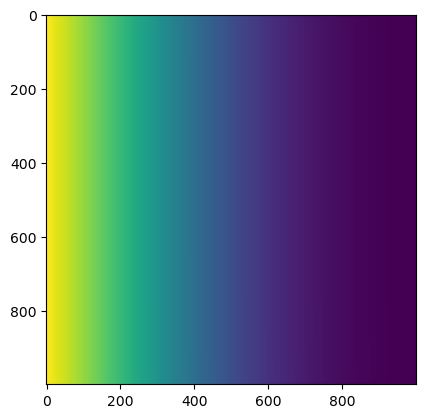

In [15]:
data = np.load(os.path.join(datapath, "results/diffusion/harmonic/petsc/LinearGMRESSolver/ILUPreconditioner/1000000/solution.npz"))
plt.imshow(data["value"])

### Matrix

A representative solution matrix can be seen by running a small problem (because of the way the problem restarts, we start with a large checkerboard initial condition)

In [94]:
Nxy = 1000
mesh = fp.Grid2D(nx=Nxy, Lx=1., ny=Nxy, Ly=1.)
phi = fp.CellVariable(mesh=mesh, value=(((mesh.x + mesh.y) * Nxy).value.astype(int) % 2) * 1.)
path = "matrices/initial_conditions/diffusion"
os.makedirs(path, exist_ok=True)
np.savez(os.path.join(path, "t=0.0.npz"), phi=phi.globalValue.reshape((Nxy, Nxy)))

In [95]:
!python diffusion.py --numberOfElements=16 \
    --output=matrices/diffusion \
    --restart=matrices/initial_conditions/diffusion/t=0.0.npz \
    --store_matrix \
    --totaltime=1

storing results in matrices/diffusion


In [96]:
from scipy import io
mtx = io.mmread("matrices/diffusion/t=1.0.mtx")
rhs = np.load("matrices/diffusion/t=1.0.rhs.npz")

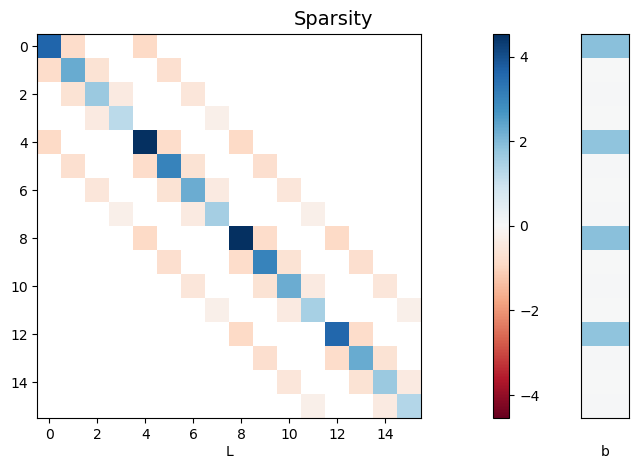

In [97]:
from fipy.matrices.scipyMatrix import _ScipyMatrix

from fipy.viewers.matplotlibViewer.matplotlibSparseMatrixViewer import MatplotlibSparseMatrixViewer

mv = MatplotlibSparseMatrixViewer()

mv.plot(matrix=_ScipyMatrix(mtx), RHSvector=rhs["rhs"])

### macOS

In [111]:
events = read_events(os.path.join(datapath, "diffusion/macOS/macos.log"))

macos = events2df(events)
macos_total = extract_total_times(macos)

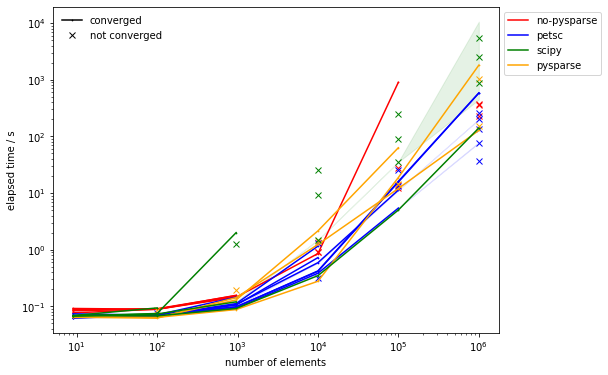

In [112]:
plot_all(macos_total)

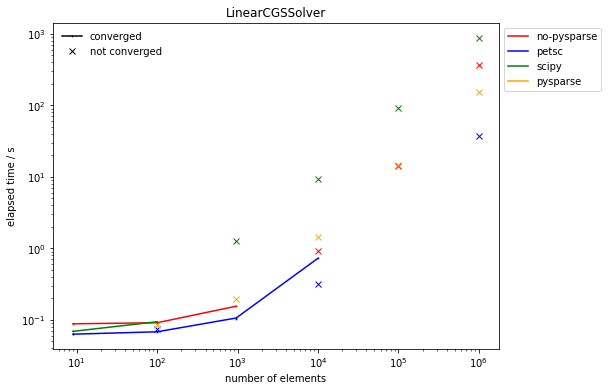

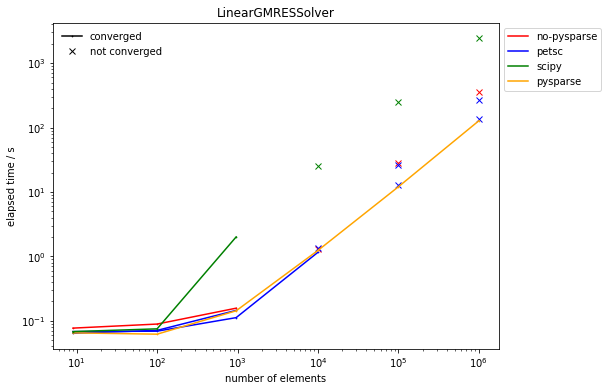

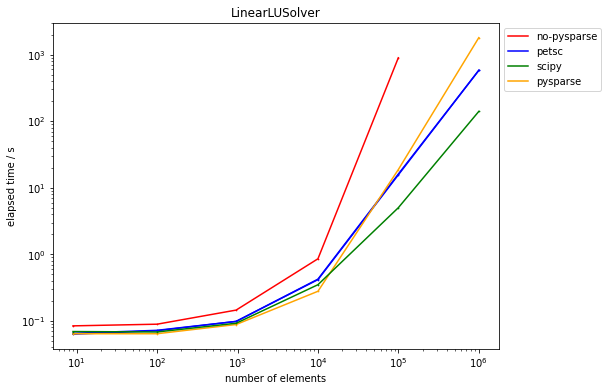

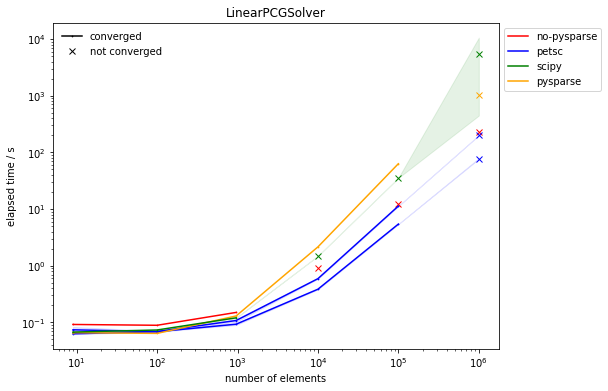

In [113]:
plot_by_solver(macos_total)

In [114]:
macos_sweep = extract_sweep_times(macos)

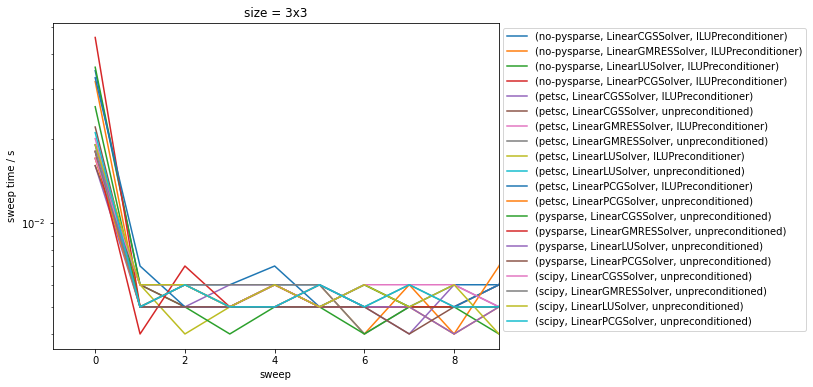

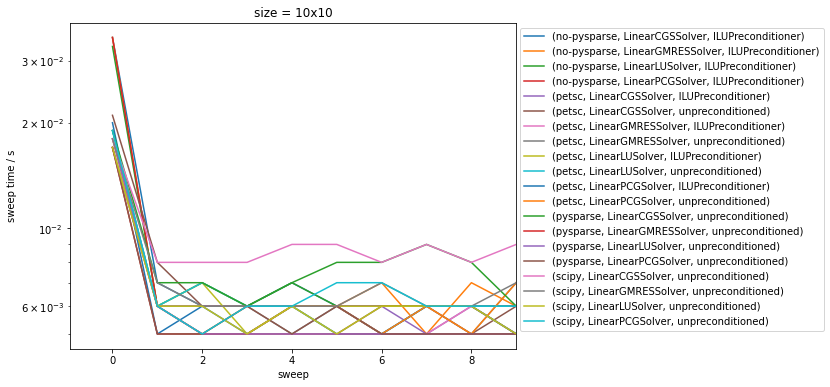

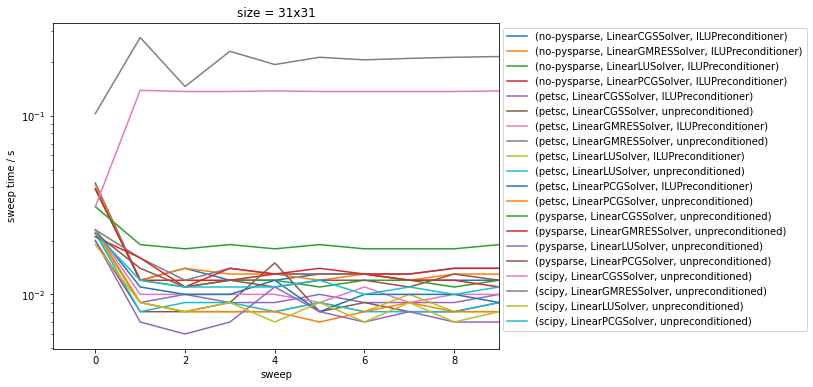

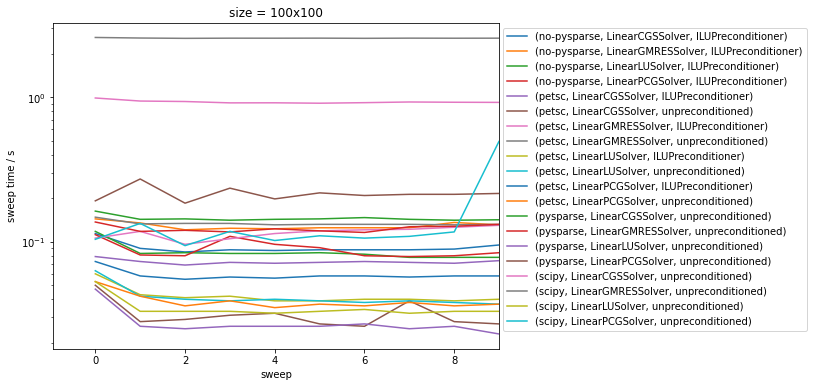

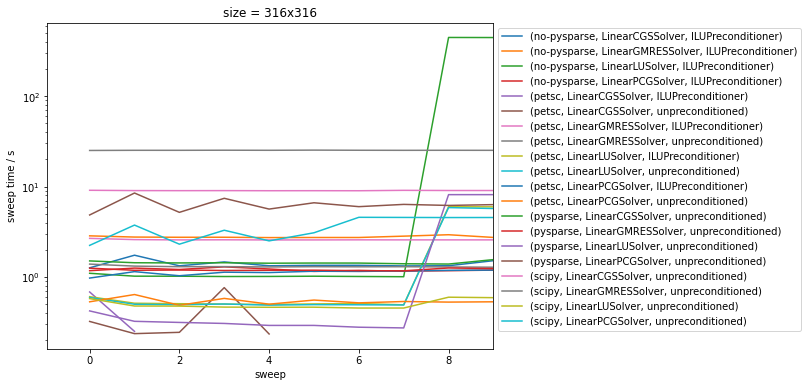

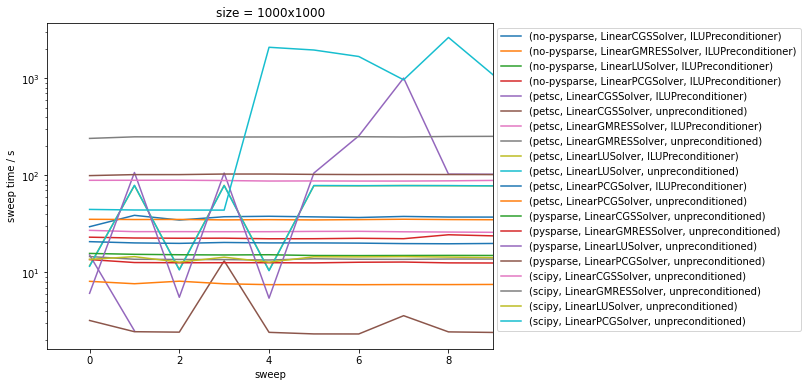

In [115]:
plot_sweep_times(macos_sweep)

In [16]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"] == "LinearGMRESSolver")],
                  macos_total[(macos_total["package.solver"] == "petsc")
                              & (macos_total["solver_class"] == "LinearGMRESSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="solution.npz", key="value",
                  diff_fn=scale_and_diff)                  

NameError: name 'linux_total' is not defined

### GPUs

In [116]:
gpu = events2df(read_events(os.path.join(datapath, "diffusion/gpu/gpu.log")))
gpu_total = extract_total_times(gpu)

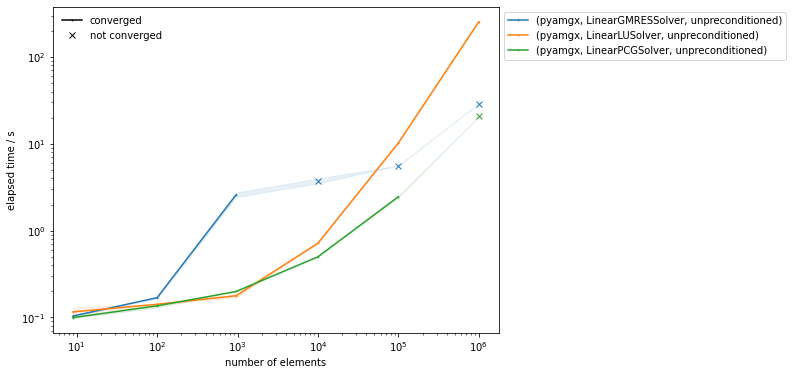

In [117]:
plot_all(gpu_total, color_by_suite=False)

In [118]:
gpu_sweep = extract_sweep_times(gpu)

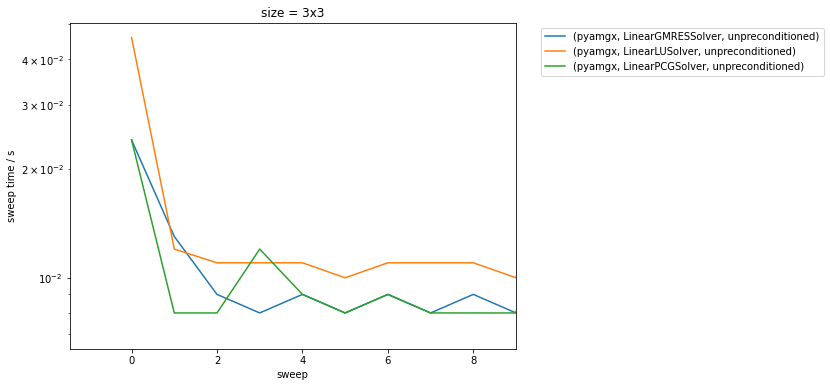

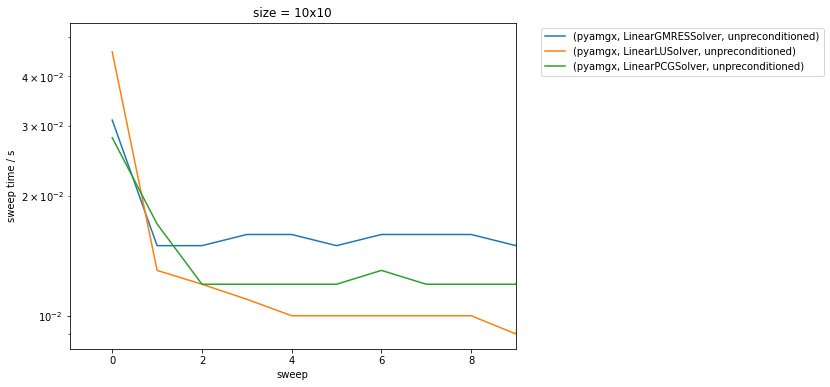

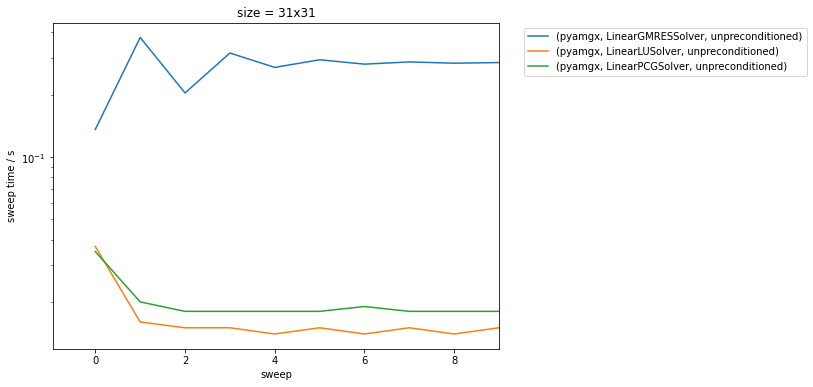

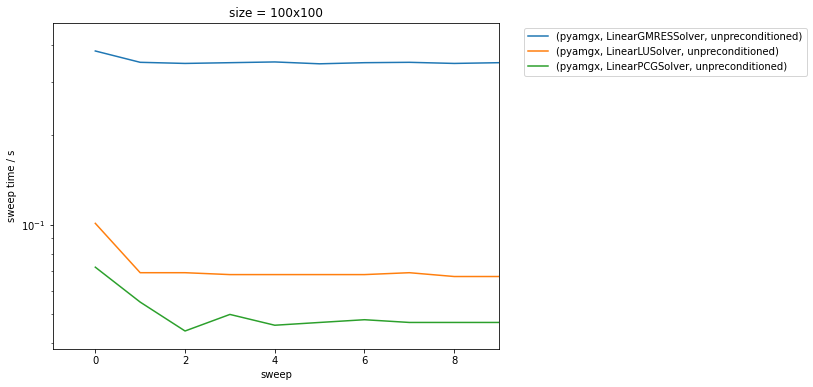

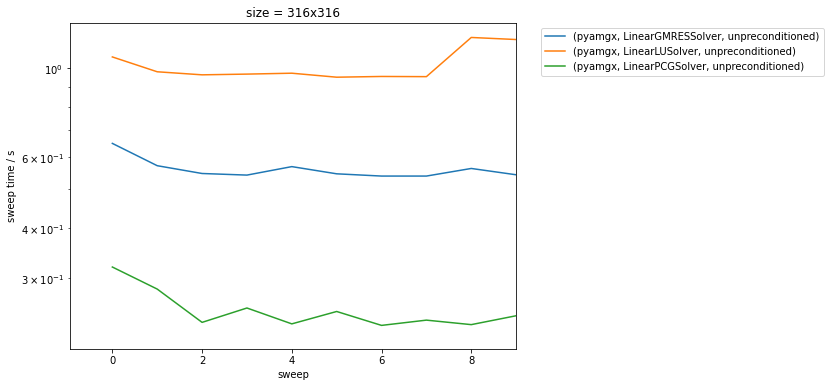

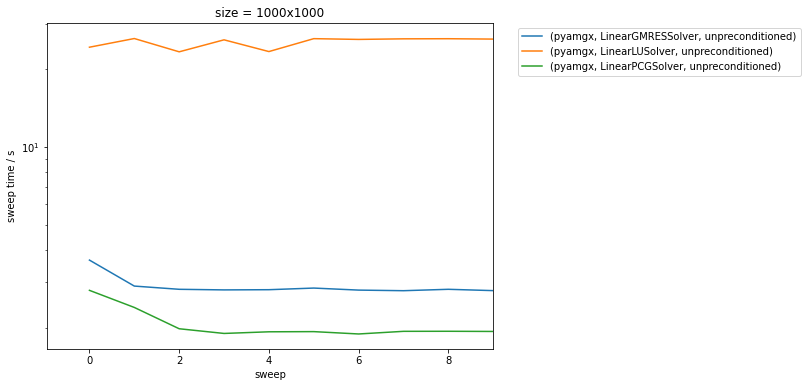

In [119]:
plot_sweep_times(gpu_sweep)

### Linux

In [120]:
events = []
for fname in glob.glob(os.path.join(datapath, "diffusion/linux/linux.*.log")):
    events.extend(read_events(fname))

linux = events2df(events)
linux_total = extract_total_times(linux)

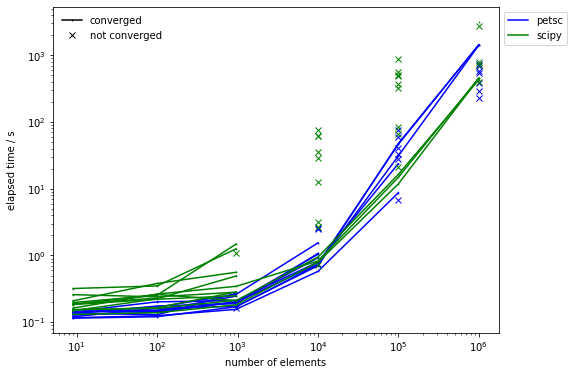

In [121]:
plot_all(linux_total)

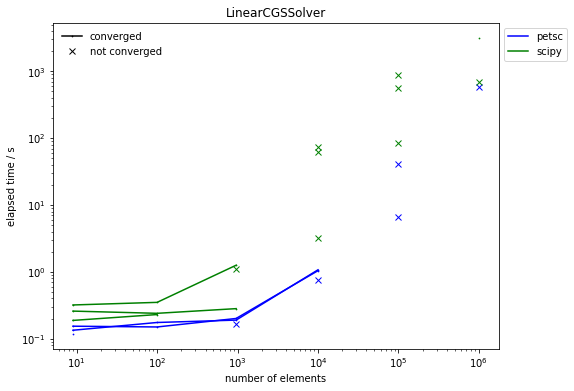

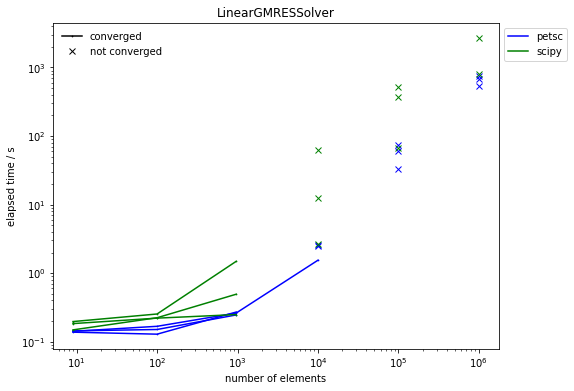

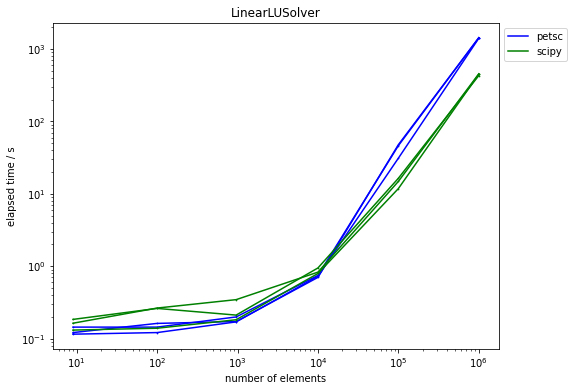

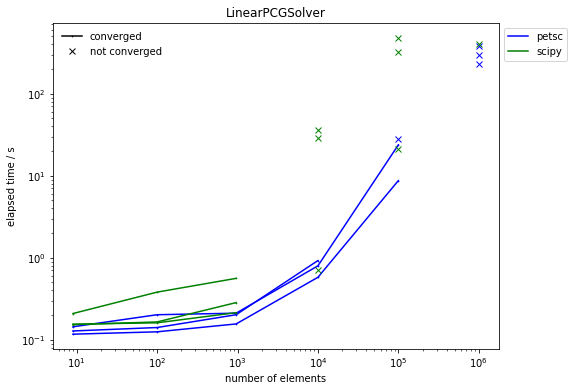

In [122]:
plot_by_solver(linux_total)

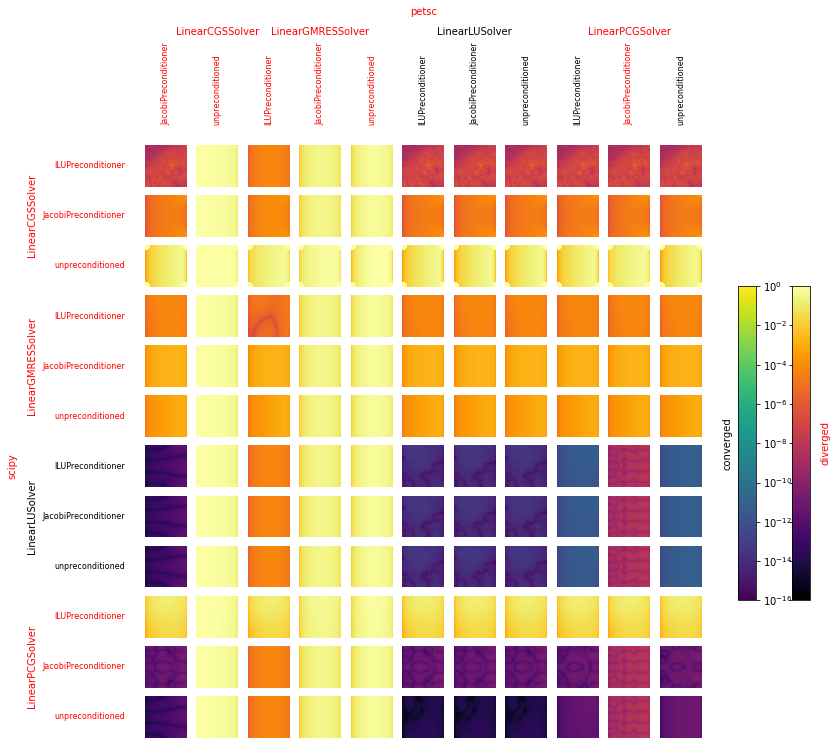

In [28]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")
                                   & (linux_total["numberOfElements"] == 316**2)],
                  linux_total[(linux_total["package.solver"] == "scipy")
                                   & (linux_total["numberOfElements"] == 316**2)],
                  by=["package.solver", "solver_class", "preconditioner"],
                  fname="solution.npz", key="value",
                  diff_fn=scale_and_diff)

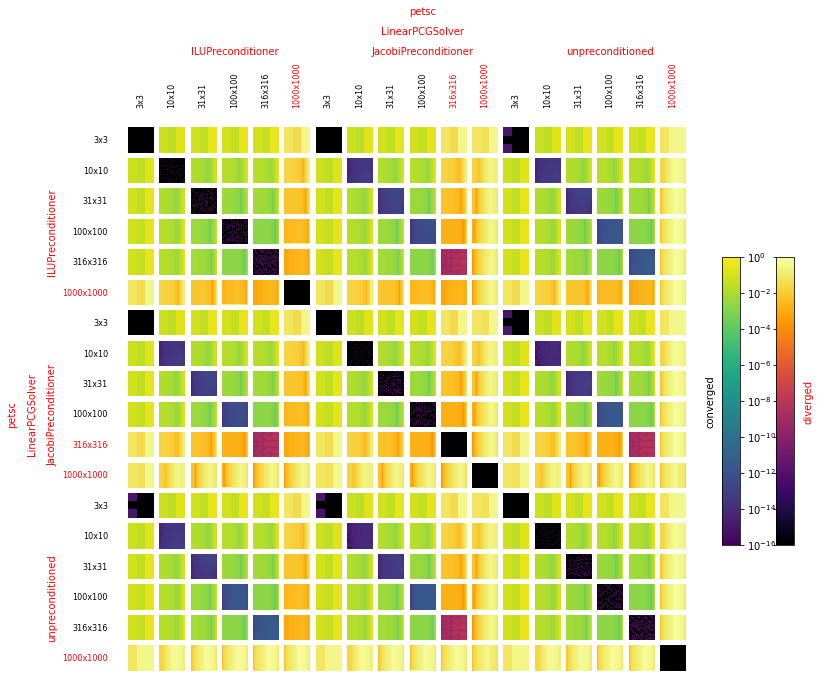

In [123]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"].isin(["LinearPCGSolver"]))],
                  linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"].isin(["LinearPCGSolver"]))],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="solution.npz", key="value",
                  diff_fn=scale_and_diff)

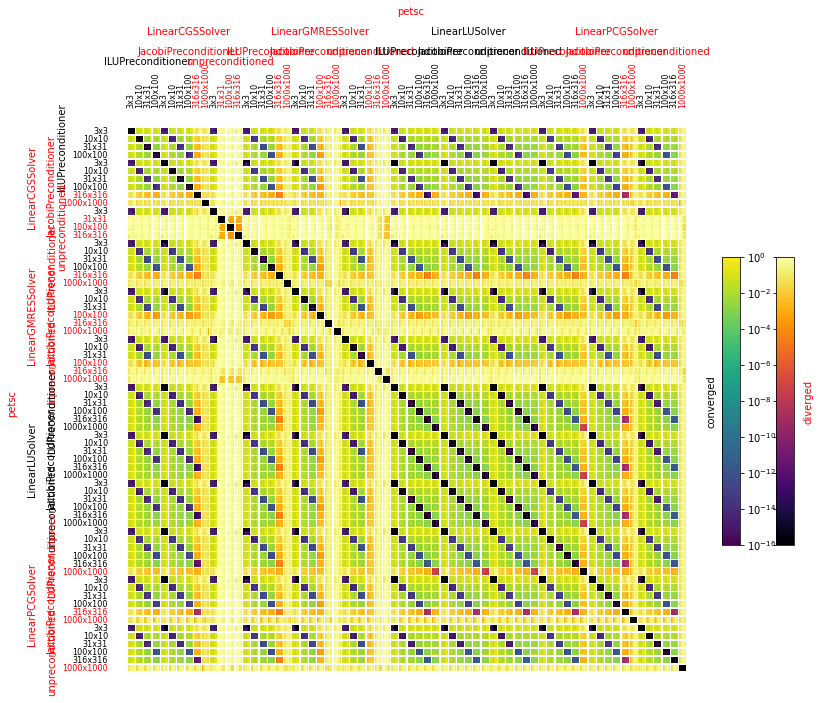

In [996]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")],
                  linux_total[(linux_total["package.solver"] == "petsc")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="solution.npz", key="value",
                  diff_fn=scale_and_diff)                  

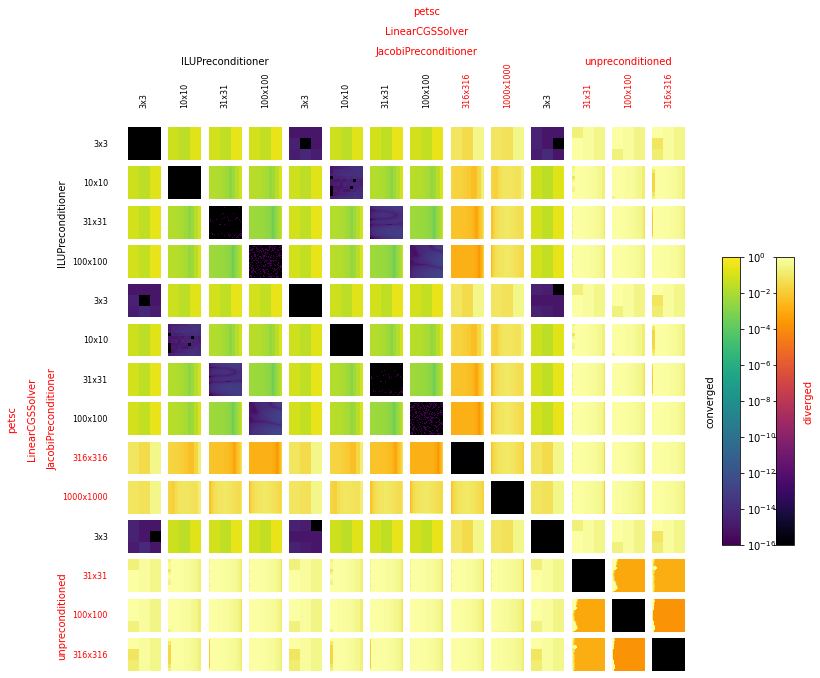

In [124]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"] == "LinearCGSSolver")],
                  linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["solver_class"] == "LinearCGSSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="solution.npz", key="value",
                  diff_fn=scale_and_diff)                  

#### arithmetic

In [126]:
events = []
for fname in glob.glob(os.path.join(datapath, "diffusion/arithmetic_diffusion/solver.*.log")):
    events.extend(read_events(fname))

arithmetic = events2df(events)
arithmetic_total = extract_total_times(arithmetic)

(10.0, 1000000.0)

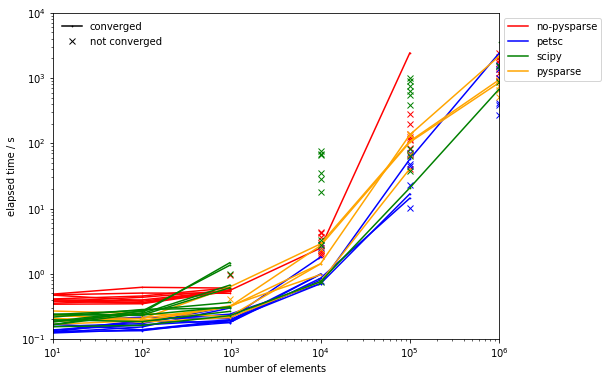

In [127]:
trilinos = arithmetic_total["package.solver"] == "no-pysparse"
petsc = arithmetic_total["package.solver"] == "petsc"
scipy = arithmetic_total["package.solver"] == "scipy"
pysparse = arithmetic_total["package.solver"] == "pysparse"

# plot_all(harmonic_total[pysparse | scipy])
plot_all(arithmetic_total)
plt.ylim(bottom=1e-1, top=1e4)
plt.xlim(left=1e1, right=1e6)

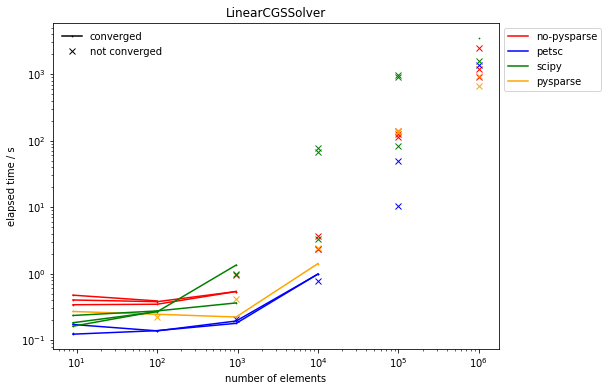

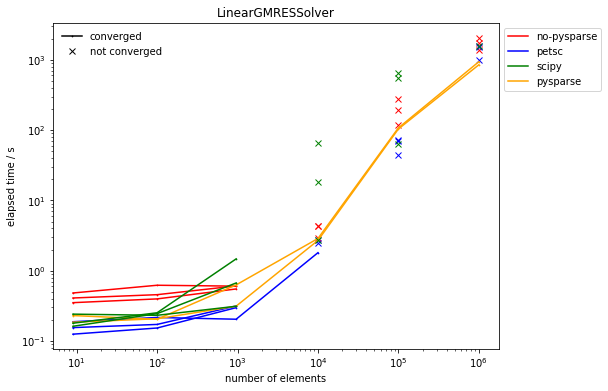

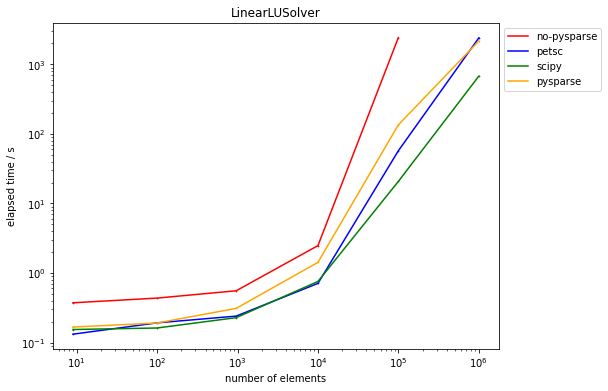

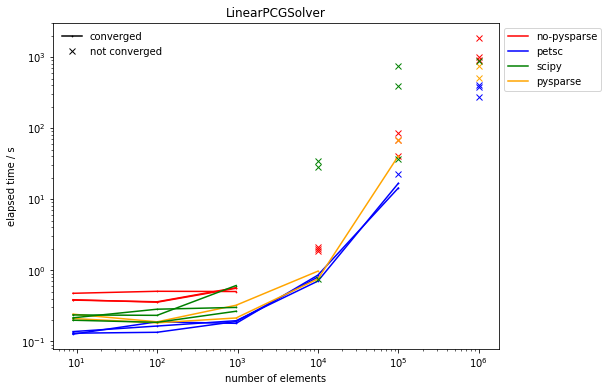

In [128]:
plot_by_solver(arithmetic_total)

#### harmonic-right

Solve
\begin{align*}
\frac{\partial\phi}{\partial t} &= \nabla\cdot\left(\phi\nabla\phi\right)
\\
\phi|_{x=0} &= 1
\\
\phi|_{x=1} &= 0.1
\end{align*}
- for one timestep of $\Delta t = 1$
- on a 2D $1\times 1$ domain
    - subdivided into $N\times N$ elements
    - where $N\equiv\sqrt{\mathtt{numberOfElements}}$. 
- The coefficient of the `DiffusionTerm`, $\phi$, is evaluated as the harmonic mean.

In [130]:
events = []
for fname in glob.glob(os.path.join(datapath, "diffusion/harmonic_right/solver.*.log")):
    events.extend(read_events(fname))

harmonic_right = events2df(events)
harmonic_right_total = extract_total_times(harmonic_right)

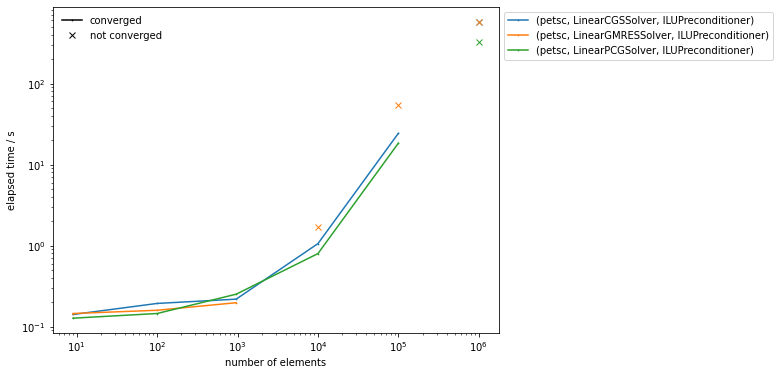

In [131]:
plot_all(harmonic_right_total, color_by_suite=False)

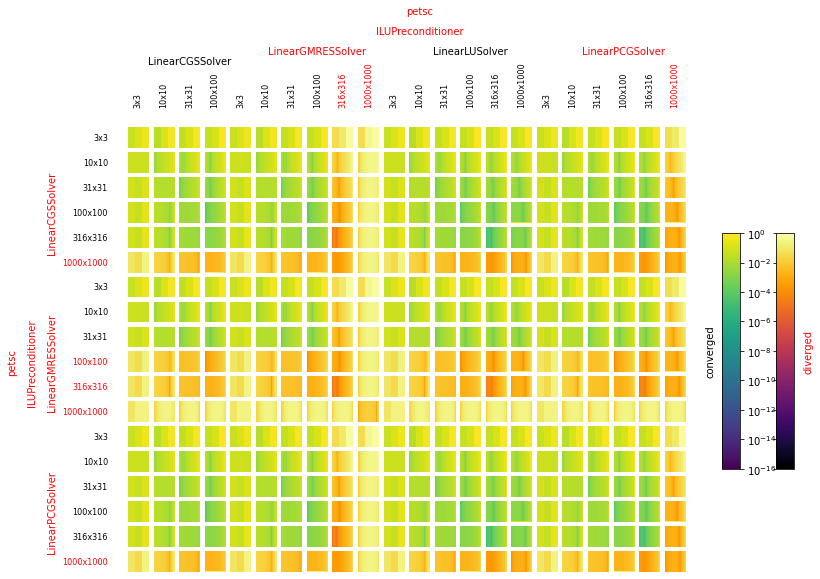

In [132]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["preconditioner"].isin(["ILUPreconditioner"]))],
                  harmonic_right_total[(harmonic_right_total["package.solver"] == "petsc")
                              & (harmonic_right_total["preconditioner"].isin(["ILUPreconditioner"]))],
                  by=["package.solver", "preconditioner", "solver_class", "numberOfElements"],
                  fname="solution.npz", key="value",
                  diff_fn=scale_and_diff)                  

#### harmonic

Solve
\begin{align*}
\frac{\partial\phi}{\partial t} &= \nabla\cdot\left(\phi\nabla\phi\right)
\\
\phi|_{x=0} &= 1
\\
\phi|_{x=1} &= 0
\end{align*}
- for one timestep of $\Delta t = 1$
- on a 2D $1\times 1$ domain
    - subdivided into $N\times N$ elements
    - where $N\equiv\sqrt{\mathtt{numberOfElements}}$. 
- The coefficient of the `DiffusionTerm`, $\phi$, is evaluated as the harmonic mean.

In [133]:
events = []
for fname in glob.glob(os.path.join(datapath, "diffusion/harmonic/solver.*.log")):
    events.extend(read_events(fname))

harmonic = events2df(events)
harmonic_total = extract_total_times(harmonic)

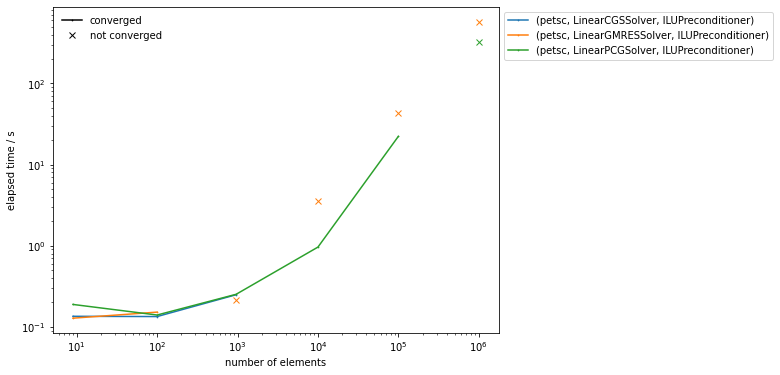

In [134]:
plot_all(harmonic_total, color_by_suite=False)

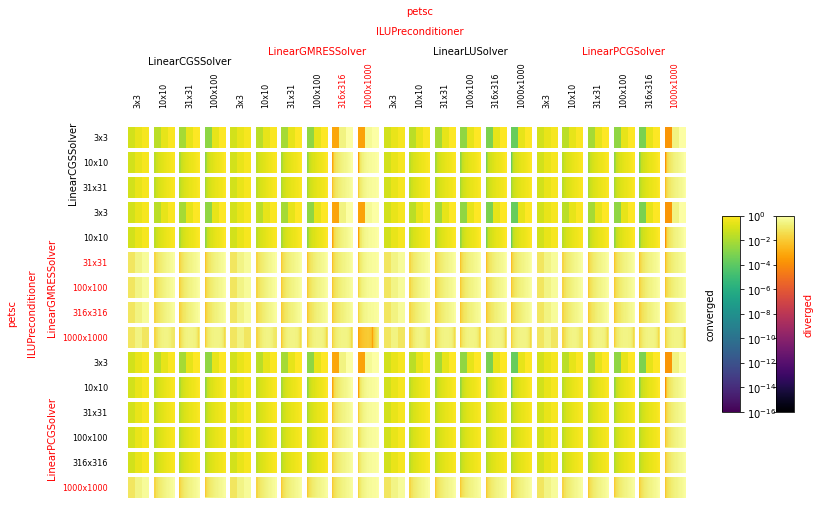

In [135]:
plot_error_matrix(linux_total[(linux_total["package.solver"] == "petsc")
                              & (linux_total["preconditioner"].isin(["ILUPreconditioner"]))],
                  harmonic_total[(harmonic_total["package.solver"] == "petsc")
                              & (harmonic_total["preconditioner"].isin(["ILUPreconditioner"]))],
                  by=["package.solver", "preconditioner", "solver_class", "numberOfElements"],
                  fname="solution.npz", key="value",
                  diff_fn=scale_and_diff)

#### constant

Solve
\begin{align*}
\frac{\partial\phi}{\partial t} &= \nabla^2\phi
\\
\phi|_{x=0} &= 1
\\
\phi|_{x=1} &= 0
\end{align*}
- for one timestep of $\Delta t = 1$
- on a 2D $1\times 1$ domain
    - subdivided into $N\times N$ elements
    - where $N\equiv\sqrt{\mathtt{numberOfElements}}$. 

In [136]:
events = []
for fname in glob.glob(os.path.join(datapath, "diffusion/constant_diffusion/solver.*.log")):
    events.extend(read_events(fname))

constant = events2df(events)
constant_total = extract_total_times(constant)

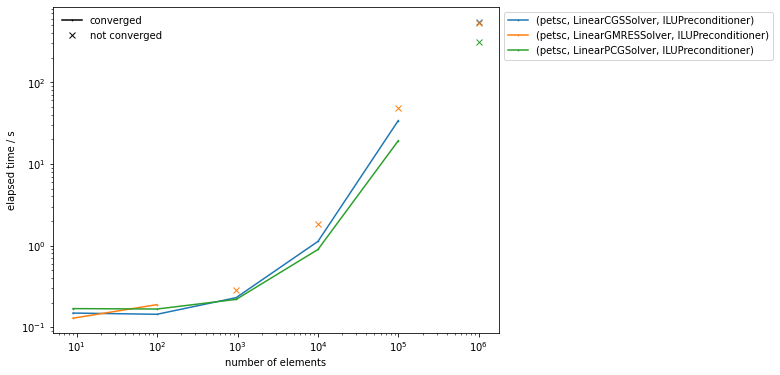

In [137]:
plot_all(constant_total, color_by_suite=False)

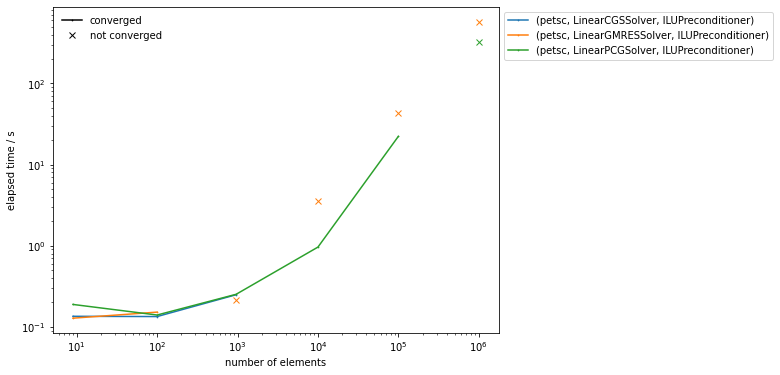

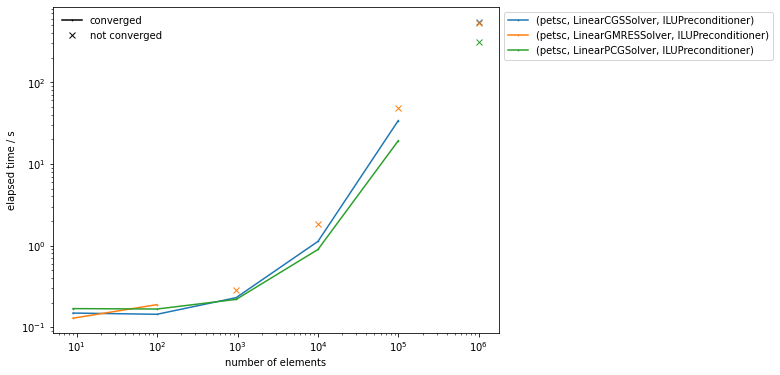

In [138]:
plot_all(harmonic_total, color_by_suite=False)
plot_all(constant_total, color_by_suite=False)

## Phase Field Benchmark 8c

(explicit nucleation, multiple seeds at random times)

- Problem 3 in *Nucleation Benchmark Problem*, Wenkun Wu *et al.*, January 16, 2020
- Based on problem 2.3 in *Benchmark problems for nucleation*, Tamás Pusztai, September 25, 2019
- Revised to [PFHub statement](https://pages.nist.gov/pfhub/benchmarks/benchmark8.ipynb/#Part-%28c%29)

$$
\begin{aligned}
\frac{\partial\phi}{\partial t} &= \nabla^2 \phi - g'(\phi) + \Delta f p'(\phi)
\\
\Delta f &= \frac{1}{6\sqrt{2}}
\\
\hat{n}\cdot\nabla\phi|_\text{all boundaries} &= 0
\end{aligned}
$$

Nuclei of $r^* = 2$ introduced at random times and random locations:
$$
\phi_i(\mathbf{r}) = \frac{1}{2}\left[
    1 - \tanh\frac{
        \left(
            \left|
                \mathbf{r} - \mathbf{r}_i
            \right| - 1.1 r^*
        \right)
    }{\sqrt{2}}
\right]
$$

Initial condition extracted from central NxN elements of 1000x1000 simulation at $t=300$.

In [9]:
data = np.load(os.path.join(datapath, "results/nucleation/nucleation23/pysparse/LinearGMRESSolver/JacobiPreconditioner/1000000/t=300.0.npz"))

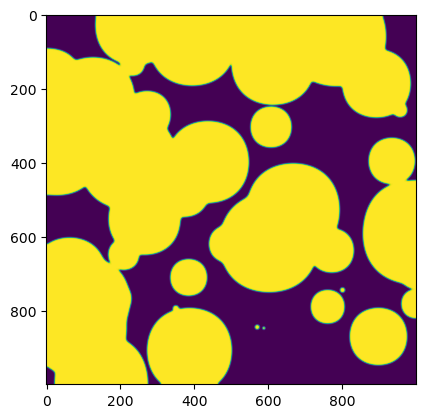

In [12]:
plt.imshow(data["phi"])

### Matrix

A representative solution matrix can be seen by running a small problem (because of the way the problem restarts, we start with a large checkerboard initial condition)

In [98]:
Nxy = 1000
mesh = fp.Grid2D(nx=Nxy, ny=Nxy)
phi = fp.CellVariable(mesh=mesh, value=((mesh.x + mesh.y) % 2) * 1.)
path = "matrices/initial_conditions/nucleation"
os.makedirs(path, exist_ok=True)
np.savez(os.path.join(path, "t=0.0.npz"), phi=phi.globalValue.reshape((Nxy, Nxy)))

We create empty nucleation and statistics files to enable the problem to run

In [99]:
times = np.random.random(0) * 6.
times.sort()
nucleii = np.concatenate((times[..., np.newaxis],
                           (np.random.random((0, 2))
                            * 1000)),
                          axis=-1)
np.save(os.path.join(path, 'nucleii.npy'), nucleii, allow_pickle=False)

In [100]:
stats = [[0., 0., 0., 0.]]
np.savetxt(os.path.join(path, 'stats.txt'),
            stats,
            delimiter="\t",
            comments='',
            header="\t".join(["time", "fraction", "particle_count", "energy"]))

In [101]:
!python nucleation.py --numberOfElements=16 --nucleation_scale=1000 \
    --output=matrices/nucleation \
    --restart=matrices/initial_conditions/nucleation/t=0.0.npz \
    --store_matrix \
    --totaltime=6

storing results in matrices/nucleation


In [102]:
from scipy import io
mtx = io.mmread("matrices/nucleation/t=6.0.mtx")
rhs = np.load("matrices/nucleation/t=6.0.rhs.npz")

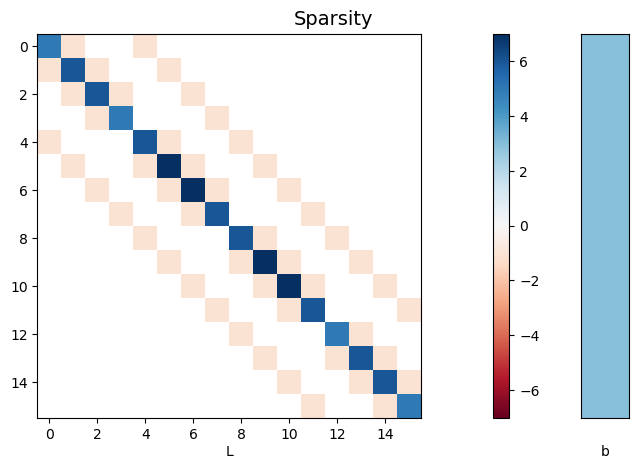

In [103]:
from fipy.matrices.scipyMatrix import _ScipyMatrix

from fipy.viewers.matplotlibViewer.matplotlibSparseMatrixViewer import MatplotlibSparseMatrixViewer

mv = MatplotlibSparseMatrixViewer()

mv.plot(matrix=_ScipyMatrix(mtx), RHSvector=rhs["rhs"])

### Results

Solve [PFHub Benchmark 8c](https://pages.nist.gov/pfhub/benchmarks/benchmark8.ipynb/#Part-%28c%29)
- for one timestep of $\Delta t = 1$
- on a 2D $N\times N$ domain
    - where $N\equiv\sqrt{\mathtt{numberOfElements}}$. 
- with an initial condition extracted from the central $N\times N$ elements from a $1000\times 1000$ simulation at $t=300$.

In [139]:
events = []
for fname in glob.glob(os.path.join(datapath, "nucleation/nucleation2[3,5,6]/solver.*.log")):
    events.extend(read_events(fname))

nucleation = events2df(events)
nucleation_total = extract_total_times(nucleation)

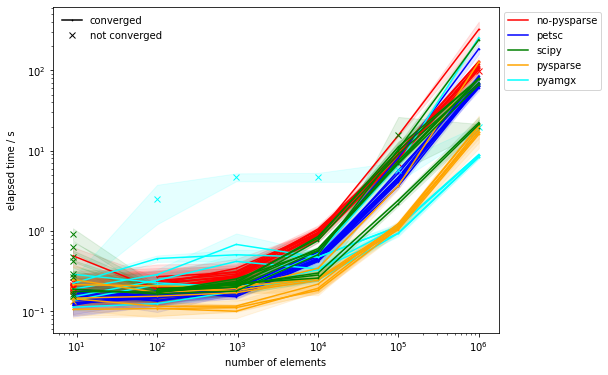

In [140]:
plot_all(nucleation_total)

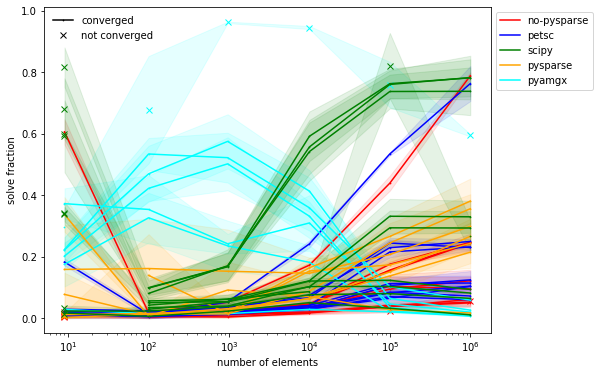

In [141]:
plot_solve_fraction(nucleation_total)

Text(0.5, 1.0, 'petsc')

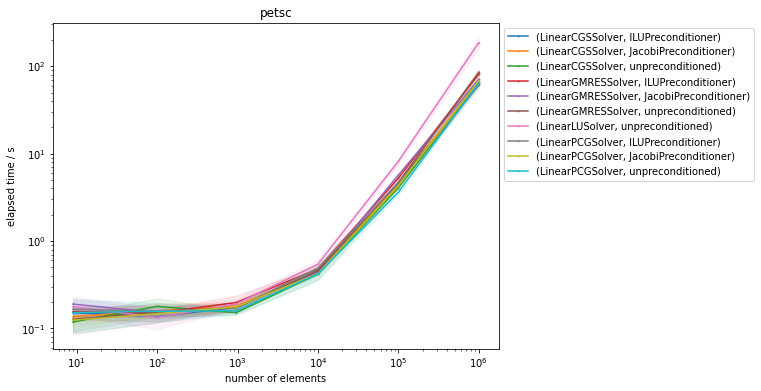

In [142]:
trilinos = nucleation_total["package.solver"] == "no-pysparse"
petsc = nucleation_total["package.solver"] == "petsc"
scipy = nucleation_total["package.solver"] == "scipy"
pysparse = nucleation_total["package.solver"] == "pysparse"
pyamgx = nucleation_total["package.solver"] == "pyamgx"

plot_all(nucleation_total[petsc], color_by_suite=False,
         by=["solver_class", "preconditioner"])
plt.title("petsc")
# plot_all(nucleation_total)
# plt.ylim(bottom=1e-1, top=1e3)
# plt.xlim(left=1e1, right=1e6)

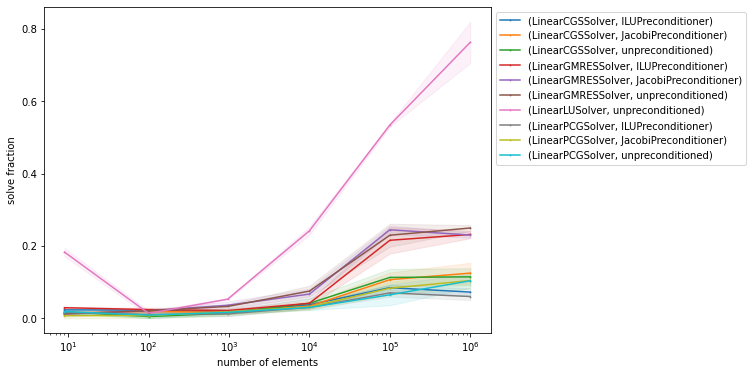

In [143]:
plot_solve_fraction(nucleation_total[petsc], color_by_suite=False,
         by=["solver_class", "preconditioner"])

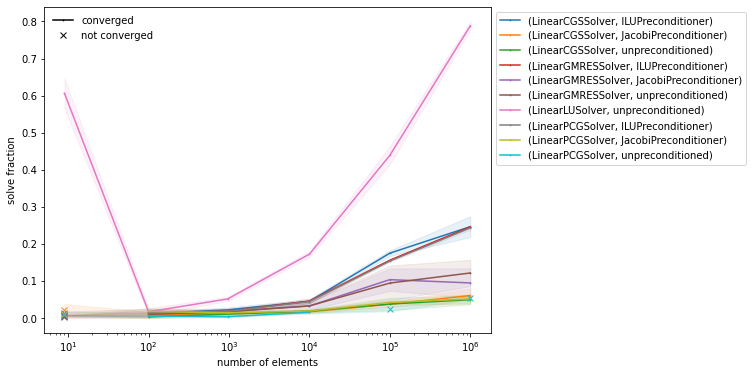

In [144]:
plot_solve_fraction(nucleation_total[trilinos], color_by_suite=False,
         by=["solver_class", "preconditioner"])

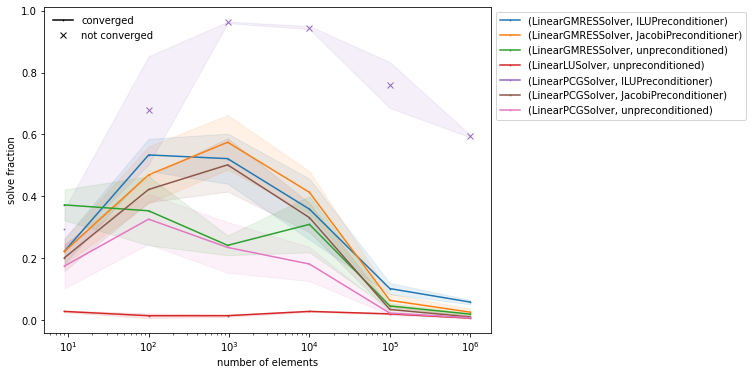

In [145]:
plot_solve_fraction(nucleation_total[pyamgx], color_by_suite=False,
         by=["solver_class", "preconditioner"])

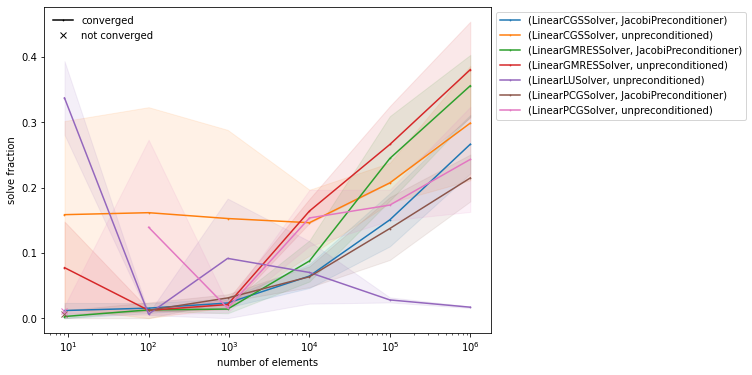

In [146]:
plot_solve_fraction(nucleation_total[pysparse], color_by_suite=False,
         by=["solver_class", "preconditioner"])

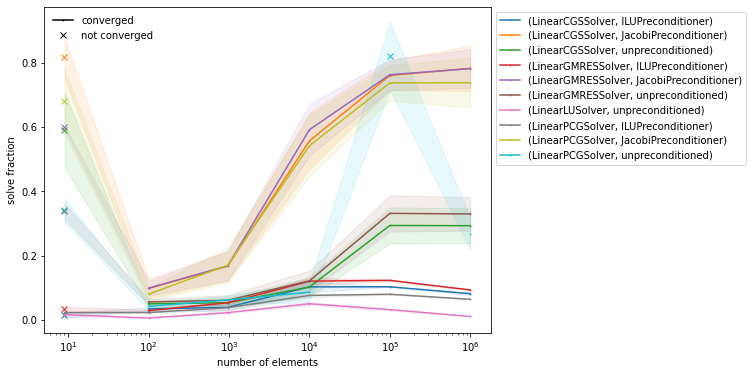

In [147]:
plot_solve_fraction(nucleation_total[scipy], color_by_suite=False,
         by=["solver_class", "preconditioner"])

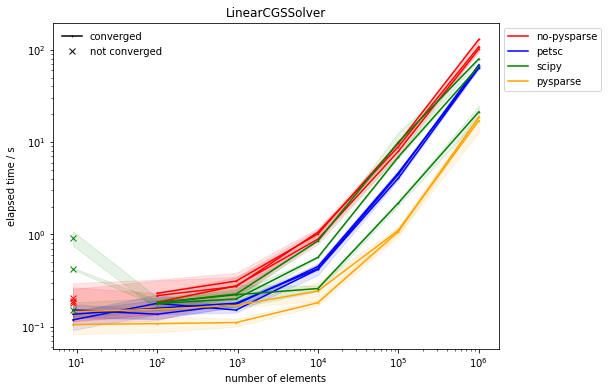

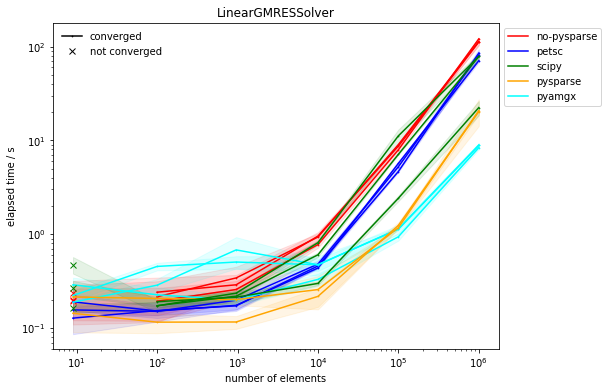

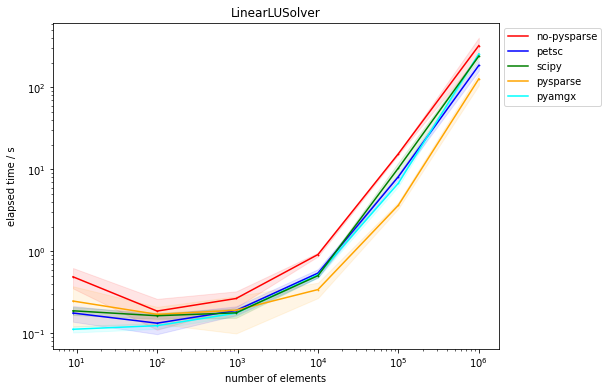

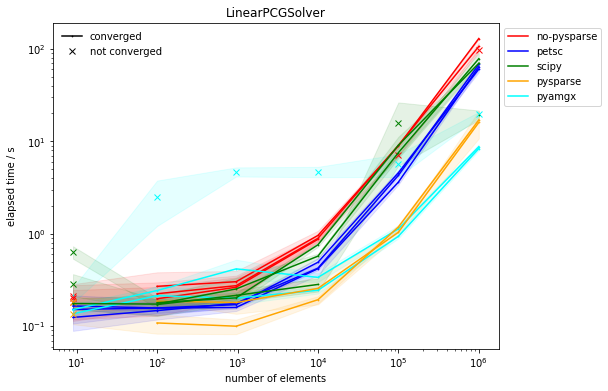

In [148]:
plot_by_solver(nucleation_total)

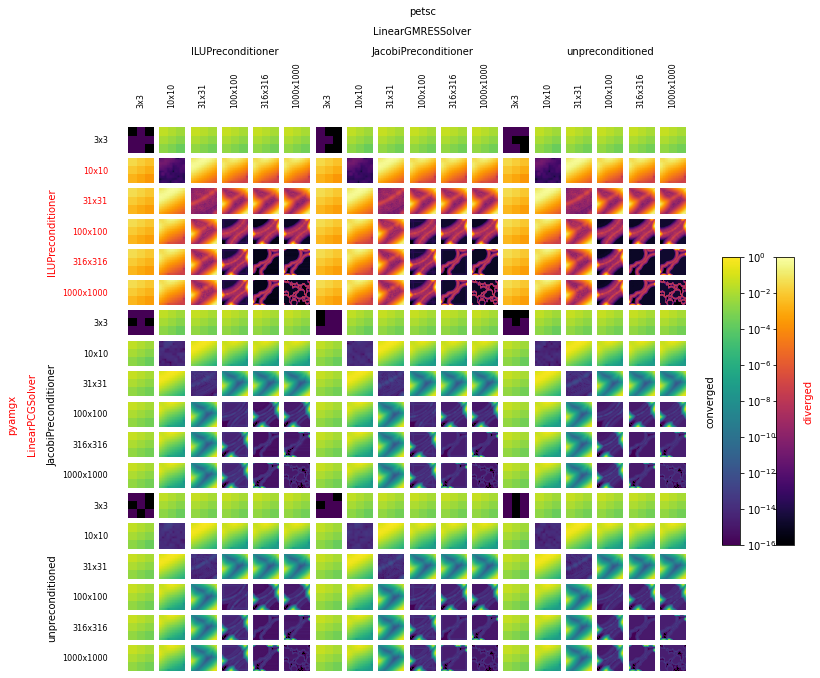

In [149]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=extract_and_diff)

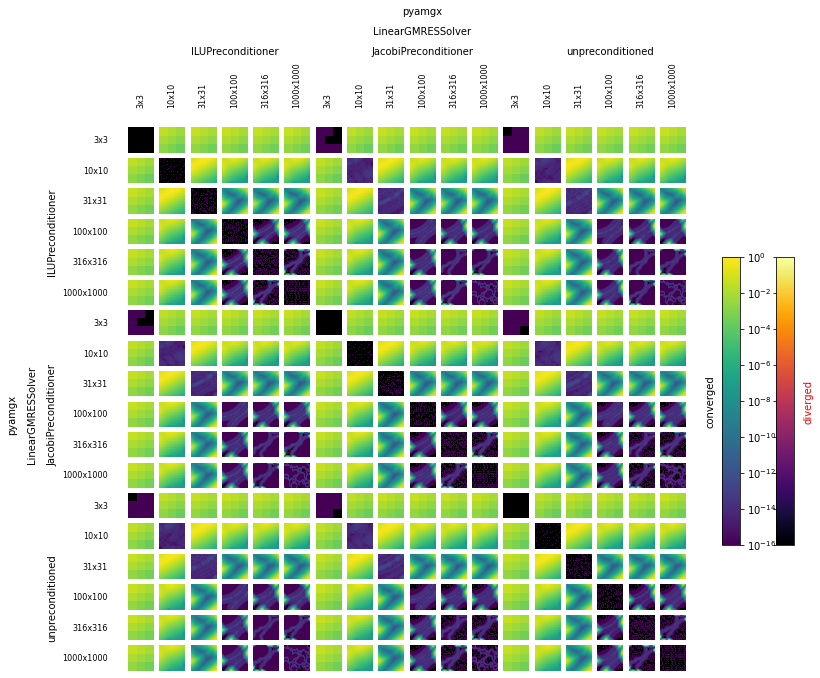

In [150]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=extract_and_diff)

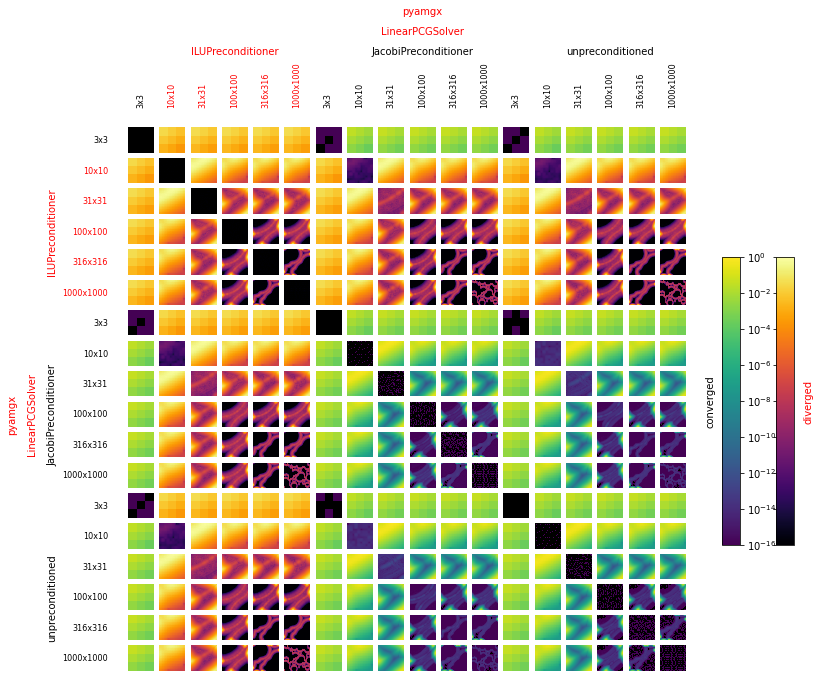

In [151]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=extract_and_diff, vmin=1e-16)

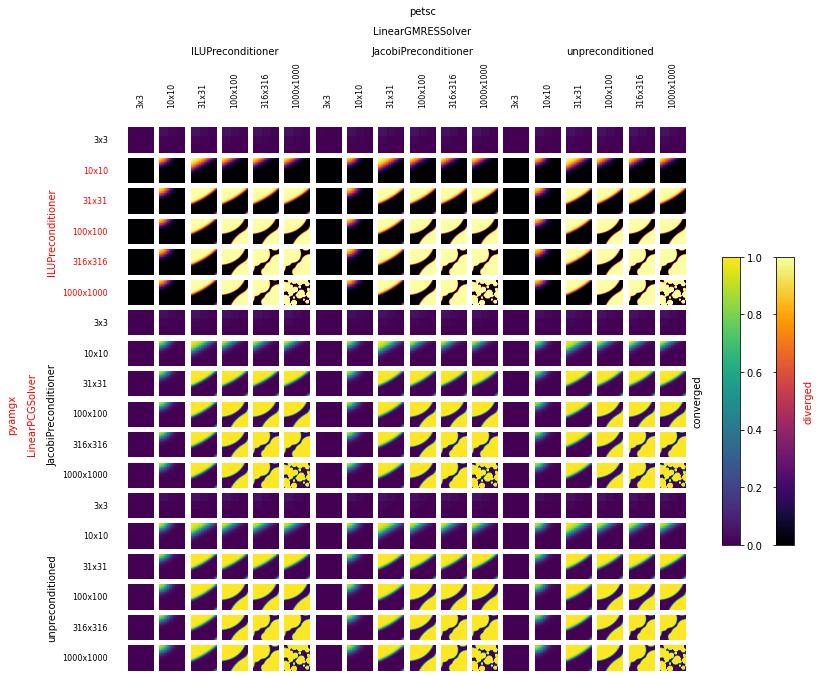

In [152]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=value1, logscale=False, vmin=0)

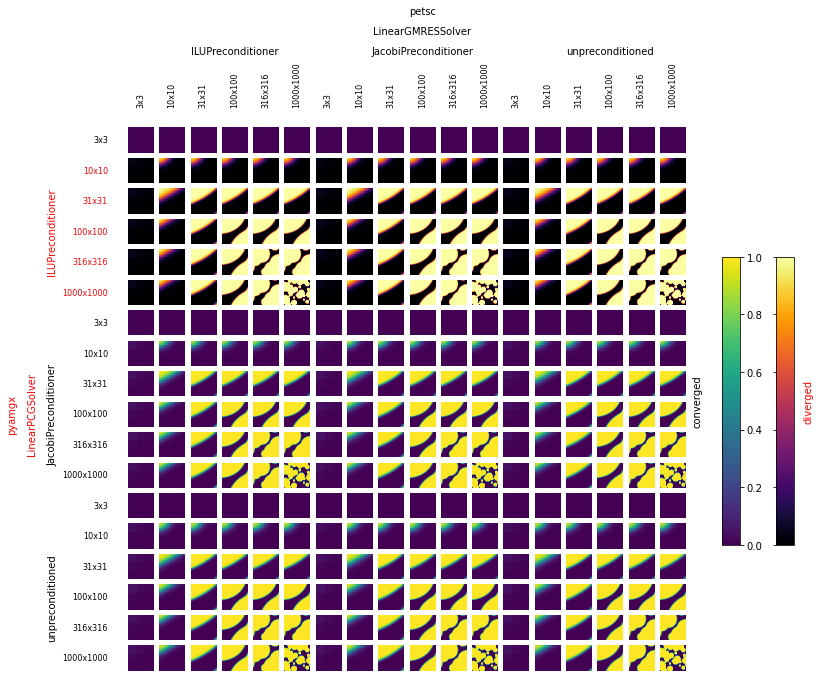

In [153]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["solver_class"] == "LinearGMRESSolver")],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["solver_class"] == "LinearPCGSolver")],
                  by=["package.solver", "solver_class", "preconditioner", "numberOfElements"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=value2, logscale=False, vmin=0)

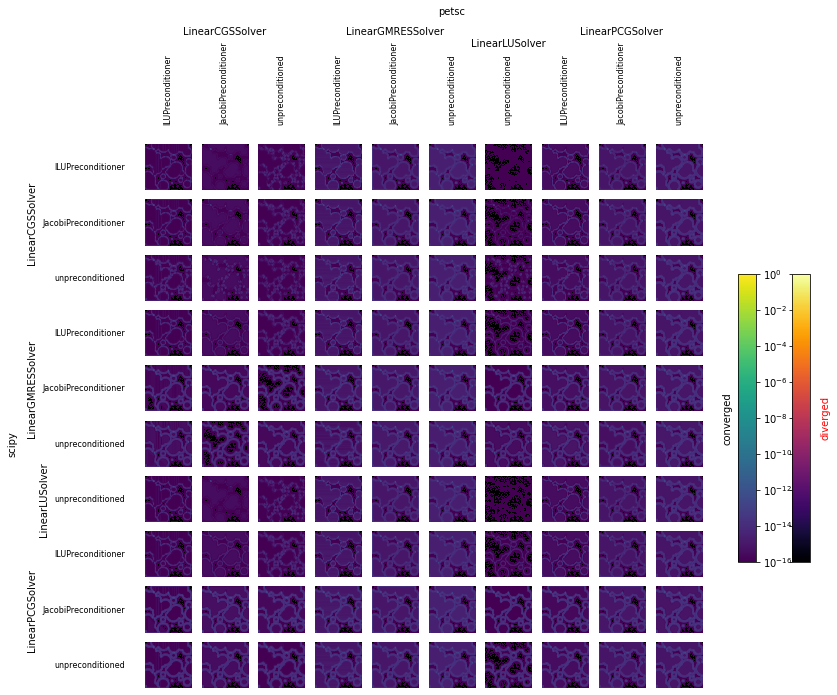

In [154]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  nucleation_total[(nucleation_total["package.solver"] == "scipy")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  by=["package.solver", "solver_class", "preconditioner"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=extract_and_diff, vmin=1e-16)

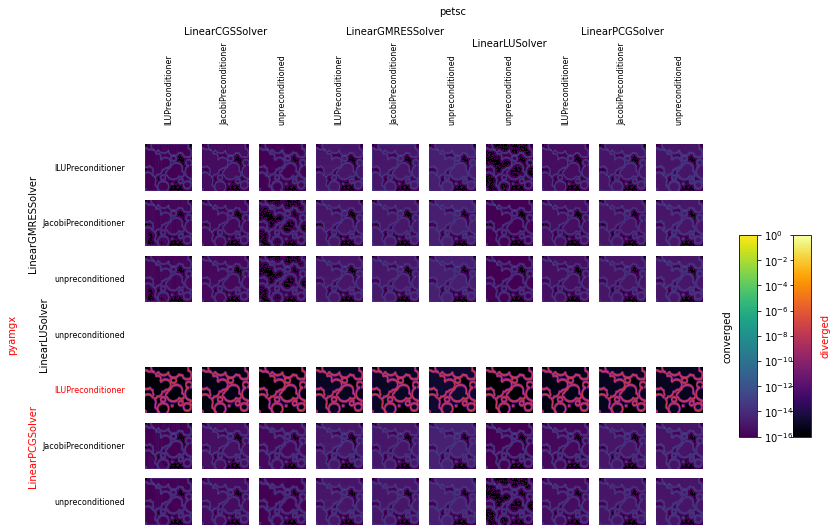

In [155]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  nucleation_total[(nucleation_total["package.solver"] == "pyamgx")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  by=["package.solver", "solver_class", "preconditioner"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=extract_and_diff, vmin=1e-16)

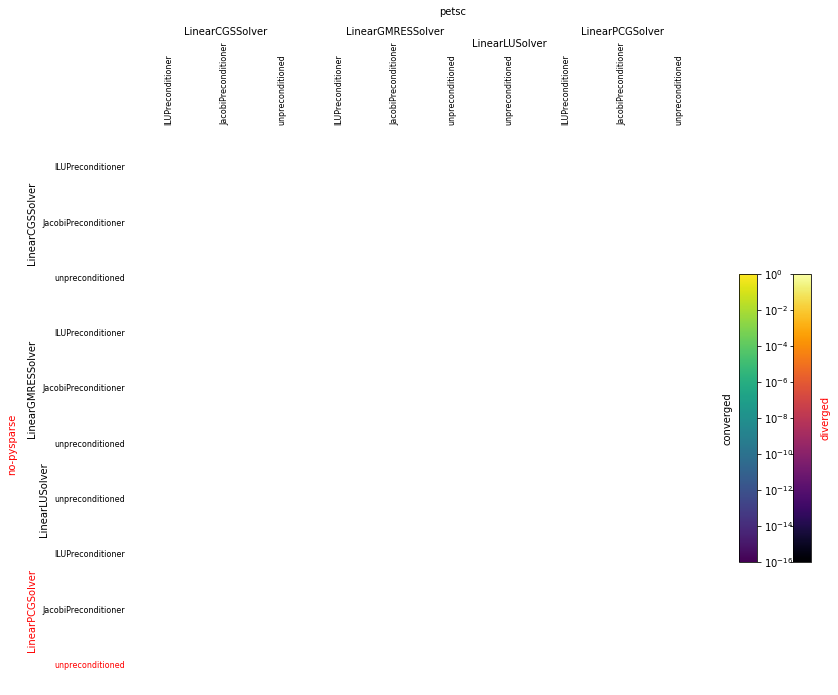

In [156]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  nucleation_total[(nucleation_total["package.solver"] == "no-pysparse")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  by=["package.solver", "solver_class", "preconditioner"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=extract_and_diff, vmin=1e-16)

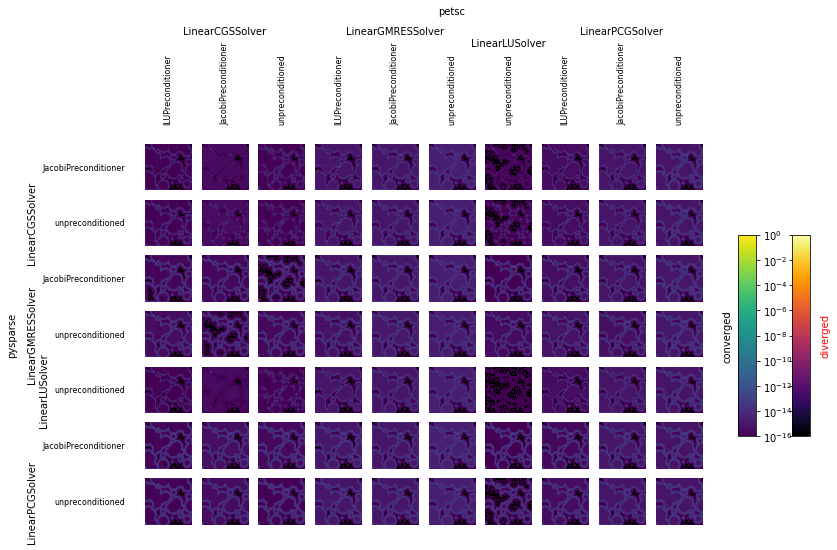

In [157]:
plot_error_matrix(nucleation_total[(nucleation_total["package.solver"] == "petsc")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  nucleation_total[(nucleation_total["package.solver"] == "pysparse")
                                   & (nucleation_total["numberOfElements"] == 10**6)],
                  by=["package.solver", "solver_class", "preconditioner"],
                  fname="t=301.0.npz", key="phi",
                  diff_fn=extract_and_diff, vmin=1e-16)

## Binary Alloy Phase Field

\begin{align}
\frac{1}{M_\phi}\frac{\partial \phi}{\partial t} &= \nabla\cdot\left(\kappa_\phi\nabla \phi\right)
- \left[
    \left(1-C\right)\frac{L_A\left(T - T_m^A\right)}{T_m^A}
    + C\frac{L_B\left(T - T_m^B\right)}{T_m^B}
\right] p'(\phi)
- \left[
    \left(1-C\right)\frac{W_A}{2}
    + C\frac{W_B}{2}
\right] g'(
\\
\frac{\partial C}{\partial t} &= \nabla\cdot\left(D_C\nabla C\right)
\\ &\quad {} + \nabla\cdot\left(
    D_C\frac{C\left(1-C\right)}{RT}
    \left\{
        \left[
            \frac{L_B\left(T - T_m^B\right)}{T_m^B}
            - \frac{L_A\left(T - T_m^A\right)}{T_m^A}
        \right] p'(\phi)
        - \frac{W_B - W_A}{2} g'(\phi)
    \right\}
    \nabla_\phi\right)
\end{align}

(haven't done this one, yet)